In [1]:
import numpy as np
from multi_task.util import util
from multi_task.util.util import layers_bn_afterrelu, layers_bn_prerelu
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import torchvision
import statsmodels.api as sm
import statsmodels.formula.api as smf

from rdrobust import rdrobust, rdbwselect, rdplot
from sklearn.metrics import pairwise_distances

from joblib import Parallel, delayed

from tigramite.independence_tests.parcorr import ParCorr

import scipy
import matplotlib
from matplotlib import pyplot as plt
plt.style.use('seaborn-paper')
import seaborn as sns
sns.set_context("paper")
from matplotlib.lines import Line2D
from labellines import labelLine, labelLines

from multi_task.rcot.independence import rcot, rcot_100

from tqdm.notebook import trange, tqdm

from concurrent.futures import ProcessPoolExecutor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score

/mnt/antares_raid/home/spiess/projects/structure-for-interpretability/multi_task/util/util.py:21: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift
/tmp/ipykernel_2526529/176123417.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


# General TODOs

- Check correctness of linear regression coefficients again. Do them for after-relu ~~(ignore everything at 0, as this distorts -> but just slightly, as all of them have the same x)~~
    - Do this for a predicted class ~~or max logit~~ (be aware that a logit is a relative measure but influence might not be too strong because it comes from a single model)
    - DONE: For predicted class: This can be correlated with KS-D's, whatever this might mean. ~~For max logit: Also some form of neuron relevance, check below.~~
- Issue: This kind of linear regression is a crude approximation to a gradient. It assumes a linear function of a neuron's activation on the output. This can just be worse than the Jacobian stuff.
    - However, Jacobians are per point. This is a global "summary"

- Check feature relevance again. On after relu. Feature relevance should be class-inspecific (as this is averaged over). This can just be used to measure how relevant neurons are, which are to a degree KS-D negative or positive. Can plot feature relevance over (sum negative KS-D's, sum positive KS-D's, sum KS-D's)

- Focus on the feature relevance. 



- Do a regression kink analysis

# Methods

In [2]:
LOCAL_STORAGE = "local_storage"
KS_NAME = "Kolmogorov-Smirnov Difference"

def load_activations_labels(network_suffix, local_storage_path=LOCAL_STORAGE):
    print(f"Loading network with suffix: {network_suffix}")

    if network_suffix == 1 or network_suffix == "1":
        print('Replacing network_suffix 1 with "".')
        network_suffix = ""


    # DONE: something might be off with the activations_dict_pre -> the spatial averaging introduces between the prerelu and afterrelu
    activations_dict_after = np.load(f"{local_storage_path}/activations_on_validation_averaged_spatial_bettercifar10single{network_suffix}_afterrelu.npy", allow_pickle=True).item()
    activations_dict_pre = np.load(f"{local_storage_path}/activations_on_validation_averaged_spatial_bettercifar10single{network_suffix}_prerelu.npy", allow_pickle=True).item()


    logits_after = np.vstack(activations_dict_after['logits'])
    layers_after = activations_dict_after['target_layer_names']

    logits_pre = np.vstack(activations_dict_pre['logits'])
    layers_pre = activations_dict_pre['target_layer_names']

    assert len(layers_after) == len(layers_pre), "Layers after and pre ReLU don't have the same length."
    
    assert (logits_after == logits_pre).all(), "Logits pre and after ReLU should be the same."
    logits = logits_after

    labels = np.load(f"{local_storage_path}/labels_bettercifar10single_afterrelu.npy")
    predicted_labels_after = logits_after.argmax(axis=1)
    predicted_labels_pre = logits_pre.argmax(axis=1)

    assert (predicted_labels_after == predicted_labels_pre).all(), "Predictions pre and after ReLU should be the same."
    predicted_labels = predicted_labels_after

    print(f"Achieved accuracy of {(predicted_labels == labels).sum() / len(labels)}")
    return activations_dict_after, activations_dict_pre, logits, layers_after, layers_pre, labels, predicted_labels

In [3]:
def produce_df_in_class(activations_dict, layers, labels, logits, layeri, neuroni, classi, quantile=None):
    acts = np.vstack(activations_dict[layers[layeri]])[:, neuroni]

    selection = labels == classi
    
    if quantile is not None:
        print("Should not use quantile=True` for passing it to `rdrobust`!")

        class_acts = acts[selection]

        try:
            xlims_class = -np.quantile(np.abs(class_acts[class_acts < 0]), quantile), np.quantile(np.abs(class_acts[class_acts > 0]), quantile)
        except:
            return None, None
        
        inlims_class = np.logical_and(acts >= xlims_class[0], acts <= xlims_class[1])

        selection = np.logical_and(selection, inlims_class)

    class_acts = acts[selection]
    logits_class = logits[:, classi][selection]

    probs = F.softmax(torch.tensor(logits), dim=1).numpy()
    probs_class = probs[:, classi][selection]

    logprobs_class = np.log(probs_class)

    domain_class = np.array(["Above threshold" if a >= 0 else "Below threshold" for a in class_acts])

    df_class = pd.DataFrame({"Probs.": probs_class,
                   "Logits": logits_class, "Log. Probs.": logprobs_class,
                   "Activations": class_acts, "Domain": domain_class})
    if quantile is not None:
        return df_class, xlims_class
    else:
        return df_class

In [4]:
def produce_df_class_logits(activations_dict, layers, logits, layeri, neuroni, classi):
    acts = np.vstack(activations_dict[layers[layeri]])[:, neuroni]

    logits_class = logits[:, classi]

    probs = F.softmax(torch.tensor(logits), dim=1).numpy()
    probs_class = probs[:, classi]

    logprobs_class = np.log(probs_class)

    domain_class = np.array(["Above threshold" if a >= 0 else "Below threshold" for a in acts])

    df_class = pd.DataFrame({"Probs.": probs_class,
                   "Logits": logits_class, "Log. Probs.": logprobs_class,
                   "Activations": acts, "Domain": domain_class})
    return df_class


In [5]:
def produce_df_max_class(activations_dict, layers, logits, layeri, neuroni, quantile=None):
    acts = np.vstack(activations_dict[layers[layeri]])[:, neuroni]
    
    selection = acts == acts

    if quantile is not None:
        print("Should not use quantile=True` for passing it to `rdrobust`!")

        try:
            xlims = -np.quantile(np.abs(acts[acts < 0]), quantile), np.quantile(np.abs(acts[acts > 0]), quantile)
        except:
            return None, None
        
        inlims = np.logical_and(acts >= xlims[0], acts <= xlims[1])

        selection = inlims

    acts = acts[selection]
    logits_max_class = logits.max(axis=1)[selection]

    probs = F.softmax(torch.tensor(logits), dim=1).numpy()
    probs_max_class = probs.max(axis=1)[selection]

    domain = np.array(["Above threshold" if a >= 0 else "Below threshold" for a in acts])

    df = pd.DataFrame({"Probs.": probs_max_class,
                   "Logits": logits_max_class,
                   "Activations": acts, "Domain": domain})
    if quantile is not None:
        return df, xlims
    else:
        return df

In [6]:
def compute_binary_regressions(logits):
    # binary log probs based on binary logistic regression
    predicted_classes = np.argmax(logits, axis=1)

    binary_regressions = []

    for classi in np.arange(logits.shape[1]):
        # label whether class i has been predicted
        labelsi = predicted_classes == classi

        # regression
        # https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
        log_reg = LogisticRegression(random_state=0, penalty='l2', solver='liblinear').fit(logits, labelsi)

        bac = balanced_accuracy_score(log_reg.predict(logits), labelsi)
        print(f"Binary logistic regression on class {classi} gave a BAC of {bac}.")

        binary_regressions.append(log_reg)

    return binary_regressions

In [7]:
def produce_df_class_feature_relevance(activations_dict, layers, labels, logits, binary_regressions, layeri, neuroni, classi, softmax_temperature=1.0):
    acts = np.vstack(activations_dict[layers[layeri]])[:, neuroni]

    selection_in_class = labels == classi
    selection_out_class = labels != classi

    acts_in_class = acts[selection_in_class]
    logits_in_class = logits[:, classi][selection_in_class]

    acts_out_class = acts[selection_out_class]
    logits_out_class = logits[selection_out_class, labels[selection_out_class]]
    logits_out_class_max = np.max(logits, axis=1)[selection_out_class]

    other_classes = np.setdiff1d(np.arange(logits.shape[1]), [classi])
    logits_other_classes_max = np.max(logits[:, other_classes], axis=1) # this gives the most likely class ignoring the one we are currently looking at
    logits_in_class_all = logits[:, classi]
    logits_in_out_class_difference = logits_in_class_all - logits_other_classes_max # this gives a likelihood ratio of the current class and the (next) most likely class
    # generally speaking: for the in-class samples this should be positive, while for the others this should be smaller (like an offset/intercept change)


    probs = F.softmax(torch.tensor(logits) * softmax_temperature, dim=1).numpy()
    probs_in_class = probs[:, classi][selection_in_class]
    probs_out_class = (1 - probs[:, classi])[selection_out_class]

    acts_all = np.concatenate([acts_in_class, acts_out_class])
    logits_all = np.concatenate([logits_in_class, logits_out_class])
    logits_all_max = np.concatenate([logits_in_class, logits_out_class_max])
    probs_all = np.concatenate([probs_in_class, probs_out_class])

    # this is for sorting
    logits_in_out_class_difference_all = np.concatenate([logits_in_out_class_difference[selection_in_class], logits_in_out_class_difference[selection_out_class]])

    domain = np.array(["Above threshold" if a >= 0 else "Below threshold" for a in acts_all])
    
    classes = np.concatenate([np.ones_like(acts_in_class, dtype=int), np.zeros_like(acts_out_class, dtype=int)])
    classes_one_hot = np.eye(2)[classes] # this will give [False, True] for the one_hot labels

    df_dict = {"Probs.": probs_all,
               "Logits": logits_all,
               "Logits max.": logits_all_max,
               "Logits Difference": logits_in_out_class_difference_all,
               "Activations": acts_all, "Classes": classes_one_hot.tolist(), "In-Class": classes_one_hot[:, 1] == 1, "Domain": domain}

    # binary log probs based on binary logistic regression
    logits_all_classes_sorted = np.concatenate([logits[selection_in_class, :], logits[selection_out_class, :]])
    df_dict["Binary Log. Probs."] = binary_regressions[classi].predict_log_proba(logits_all_classes_sorted)[:, 1]
    df_dict["Binary Probs."] = binary_regressions[classi].predict_proba(logits_all_classes_sorted)[:, 1]
    
    df_dict["Binary Logits"] = binary_regressions[classi].decision_function(logits_all_classes_sorted) # the scores are the same as the logits
    # df_dict["Binary Logits"] = np.log(df_dict["Binary Probs."]/(1-df_dict["Binary Probs."]))

    df = pd.DataFrame(df_dict)
    
    return df

In [8]:
def estimate_rdd_effect(y, x, alpha=0.05, bwselect='mserd'):
    try:
        out = rdrobust(y=y, x=x, bwselect=bwselect)
    except Exception as e:
        print("rdorobust failed")
        return np.nan

    pval = out.pv.loc["Robust"][0]

    if pval >= alpha:
        est = np.nan
    else:
        cis = out.ci.loc["Robust"].to_numpy()

        # if they have different signs, use the middle
        all_same = np.all(np.sign(cis) == np.sign(cis)[0])
        if all_same:
            est = np.abs(cis).min() * np.sign(cis)[0]
        else:
            est = np.mean(cis)

    return est

In [9]:
def triangular_kernel(R, c, hs):
    if R < 0:
        h = np.abs(hs[0])
    else:
        h = np.abs(hs[1])

    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)

In [10]:
def fit_binomial_GLM(y, X, print_summary=False):
    
    pval, coef, std_err = np.nan, np.nan, np.nan
    significant_005 = False
    
    try:
        glm_binom = sm.GLM(y, X, family=sm.families.Binomial())
        res = glm_binom.fit()

        pval, coef, std_err = res.pvalues['Activations'], res.params['Activations'], res.bse['Activations']
        significant_005 = pval < 0.05

        if print_summary:
            print(res.summary())
    except:
        print("Computing binomial GLM failed!")

    d = {'Estimate': coef, 'Estimate Std.': std_err, 'Estimate pvalue': pval, 'Estimate significant (alpha=0.05)': significant_005}

    return d

def fit_OLS(y, X, print_summary=False):

    pval, coef, std_err = np.nan, np.nan, np.nan
    significant_005 = False

    pval_intercept, coef_intercept, std_err_intercept = np.nan, np.nan, np.nan
    significant_005_intercept = False

    rsquared = np.nanmean

    try:
        X_ = sm.add_constant(X)
        ols = sm.OLS(y, X_)
        res = ols.fit()

        pval, coef, std_err = res.pvalues['Activations'], res.params['Activations'], res.bse['Activations']
        significant_005 = pval < 0.05

        pval_intercept, coef_intercept, std_err_intercept = res.pvalues['const'], res.params['const'], res.bse['const']
        significant_005_intercept = pval_intercept < 0.05

        rsquared = res.rsquared

        if print_summary:
            print(res.summary())
    except:
        print("Computing OLS failed!")

    d = {'Estimate': coef, 'Estimate Std.': std_err, 'Estimate pvalue': pval, 'Estimate significant (alpha=0.05)': significant_005, 'Intercept': coef_intercept, 'Intercept Std.': std_err_intercept, 'Intercept pvalue': pval_intercept, 'Intercept significant (alpha=0.05)': significant_005_intercept, 'R-squared': rsquared}

    return d

def pos_full_activations_regression(df_class):
    X_full = df_class['Activations']
    X_pos = df_class['Activations'][df_class['Activations'] > 0]

    y_full = df_class['Probs.']
    y_pos = df_class['Probs.'][df_class['Activations'] > 0]

    data = [(y_pos, X_pos), (y_full, X_full)]

    pos_res, full_res = [fit_OLS(y, X) for (y, X) in data]
    return pos_res, full_res
    

In [11]:
def est_left_right(df_class, xlims_class):
    if df_class is None:
        return np.nan, np.nan

    weights = np.array([triangular_kernel(a, 0.0, xlims_class) for a in df_class['Activations']])
    left = df_class['Activations'] < 0
    right = df_class['Activations'] > 0

    if left.sum() == 0 or right.sum() == 0:
        return np.nan, np.nan

    X_left = sm.add_constant(df_class['Activations'][left])
    y_left = df_class['Logits'][left]

    X_right = sm.add_constant(df_class['Activations'][right])
    y_right = df_class['Logits'][right]

    res_wls_left = sm.WLS(y_left, X_left, weights=weights[left]).fit()
    res_wls_right = sm.WLS(y_right, X_right, weights=weights[right]).fit()

    est_left = res_wls_left.predict([1, 0])[0]
    est_right = res_wls_right.predict([1, 0])[0]

    return est_left, est_right

In [12]:
def bootstrapped_rdd(df_class, xlims_class, bootn=1000, njobs=4):
    if df_class is None:
        return np.nan, np.nan

    results = Parallel(n_jobs=njobs)(delayed(est_left_right)(df_class.sample(frac=1, replace=True), xlims_class)
                          for _ in range(bootn))
    results = np.array(results)
    diffs = results[:, 1, np.newaxis] - results[np.newaxis, :, 0]
    return np.nanmean(diffs), np.nanstd(diffs)

In [13]:
def est_pcorr(df_class_fr, on="Probs."):
    pval, coef = np.nan, np.nan
    significant_005 = False

    try:
        XY = df_class_fr[["Activations", on]].to_numpy()
        Z = np.vstack(df_class_fr["Classes"].to_numpy())
        XYZ = np.hstack([XY, Z]).T

        coef = ParCorr().get_dependence_measure(XYZ, None)
        pval = ParCorr().get_analytic_significance(coef, XYZ.shape[1], XYZ.shape[0], None)

        significant_005 = pval < 0.05
    except:
        print("Computing ParCorr failed!")

    d = {'Estimate': coef, 'Estimate pvalue': pval, 'Estimate significant (alpha=0.05)': significant_005}

    return d

def est_rcot(df_class_fr, on="Probs."):
    pval, coef = np.nan, np.nan
    significant_005 = False

    try:
        XY = df_class_fr[["Activations", on]].to_numpy()
        Z = np.vstack(df_class_fr["Classes"].to_numpy())
        XYZ = np.hstack([XY, Z])

        coef, pval, _ = rcot(XYZ[:, 0], XYZ[:, 1], XYZ[:, 2:], approx="hbe")

        significant_005 = pval < 0.05
    except:
        print("Computing RCOT failed!")

    d = {'Estimate': coef, 'Estimate pvalue': pval, 'Estimate significant (alpha=0.05)': significant_005}

    return d

In [14]:
def prepare_df_class_fr_for_regression(df_class_fr):
    df_in_class = df_class_fr[df_class_fr["In-Class"] == True]
    x_in_class = df_in_class["Activations"]
    y_in_class = df_in_class["Binary Logits"]

    df_out_class = df_class_fr[df_class_fr["In-Class"] == False]
    x_out_class = df_out_class["Activations"]
    y_out_class = df_out_class["Binary Logits"]

    return (x_in_class, y_in_class), (x_out_class, y_out_class)

In [15]:
def load_ksd_dataframe_cifar10():
    layers = range(0, 15)
    networks = ["", "2", "3", "4", "5"]
    df_list = []
    for n in networks:
        for l in layers:
            ks_diff_path = f"wasser_dists/wasser_ks_diff_attr_hist_bettercifar10single{n}_{l}.npy"
            ks_diff = np.load(ks_diff_path, allow_pickle=True).item()
            df = pd.DataFrame.from_dict(ks_diff)
            df = df.unstack().reset_index().rename(columns={"level_0": "Neuron", "level_1": "Class", 0: KS_NAME})
            df["Layer"] = int(l)+2
            df["Network"] = int(n) if n != "" else 1
            df = df[["Network", "Layer", "Neuron", "Class", KS_NAME]]
            df_list.append(df)
    df_ks_cifar = pd.concat(df_list)
    return df_ks_cifar

### How to get a good difference in slopes? 
- Numerically: Bootstrap
- Use Test Statistic: https://stats.stackexchange.com/questions/93540/testing-equality-of-coefficients-from-two-different-regressions
    - This discussion references different methods. I think the more general SUR (Seeminglu Unrelated Regression) approach is unnecessary because the slopes are by definition independent, because they use different iid samples.

The test statistic:
$$Z = \frac{\beta_1 - \beta_2}{\sqrt{(SE\beta_1)^2 + (SE\beta_2)^2}},$$
where $SE\beta_i$ is the standard error of $\beta_i$.

In [16]:
def regress_in_class_out_class(df_class_fr):
    data_in_class, data_out_class = prepare_df_class_fr_for_regression(df_class_fr)
    regress_in, regress_out = scipy.stats.linregress(*data_in_class), scipy.stats.linregress(*data_out_class)
    return (regress_in.slope, regress_in.stderr), (regress_out.slope, regress_out.stderr)

In [17]:
def test_statistic_difference_slopes(regress_in_slope, regress_in_stderr, regress_out_slope, regress_out_stderr):
    return (regress_out_slope - regress_in_slope) / np.sqrt(regress_out_stderr**2 + regress_in_stderr**2)

In [18]:
def compute_slope_diff_test_statistic(df_class_fr):
    (regress_in_slope, regress_in_stderr), (regress_out_slope, regress_out_stderr) = regress_in_class_out_class(df_class_fr)
    return test_statistic_difference_slopes(regress_in_slope, regress_in_stderr, regress_out_slope, regress_out_stderr)

# Prepare Data (only network 1)

In [19]:
activations_dict_after, activations_dict_pre, logits, layers_after, layers_pre, labels, predicted_labels = load_activations_labels("")
binary_regressions = compute_binary_regressions(logits)

Loading network with suffix: 
Achieved accuracy of 0.9252
Binary logistic regression on class 0 gave a BAC of 0.9667510233008463.
Binary logistic regression on class 1 gave a BAC of 0.9857820170635508.
Binary logistic regression on class 2 gave a BAC of 0.9592765661848833.
Binary logistic regression on class 3 gave a BAC of 0.9395897302621659.
Binary logistic regression on class 4 gave a BAC of 0.969456230149861.
Binary logistic regression on class 5 gave a BAC of 0.9518007821537071.
Binary logistic regression on class 6 gave a BAC of 0.9786714398478589.
Binary logistic regression on class 7 gave a BAC of 0.9752721602448721.
Binary logistic regression on class 8 gave a BAC of 0.9831238132925936.
Binary logistic regression on class 9 gave a BAC of 0.9820076160971812.


# "My" Bayesian Feature Relevance without any testing
see Agenda Note

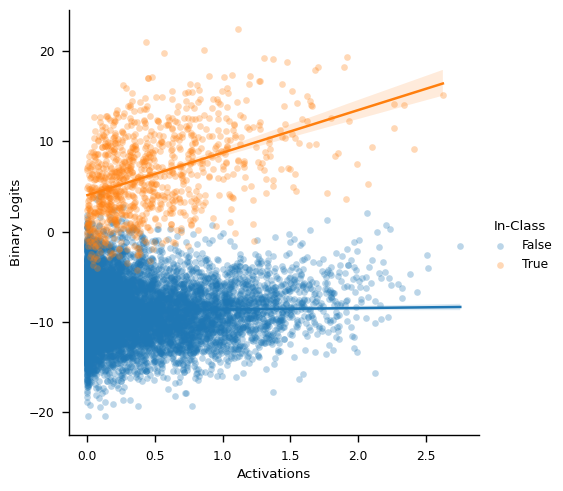

In [20]:
layeri, neuroni = 14, 21
classi = 4

df_class_fr = produce_df_class_feature_relevance(activations_dict_after, layers_after, predicted_labels, logits, binary_regressions, layeri, neuroni, classi)

ax = sns.lmplot(x = "Activations", y = "Binary Logits", data=df_class_fr, hue="In-Class", scatter_kws={'alpha':0.3})
ax

# Slope Difference Test Statistics for all layers, neurons, classes (CIFAR10)

In [21]:
try:
    df_slope_diff_test_stat = pd.read_csv("local_storage/df_slope_diff_test_stat.csv")
except:
    df_slope_diff_test_stat = None

In [22]:
recompute = False
if df_slope_diff_test_stat is None or recompute:
    df_list = []
    for network in ["", 2, 3, 4, 5]:
        activations_dict_after, activations_dict_pre, logits, layers_after, layers_pre, labels, predicted_labels = load_activations_labels(network)
        binary_regressions = compute_binary_regressions(logits)
        
        for layer in activations_dict_after.keys():
            if layer in ['logits', 'target_layer_names']:
                continue
            for neuroni in range(activations_dict_after[layer][0].shape[1]):
                for classi in range(10):
                    df_class_fr = produce_df_class_feature_relevance(activations_dict_after, layers_after, predicted_labels, logits, binary_regressions, layers_after.index(layer), neuroni, classi)

                    (regress_in_slope, regress_in_stderr), (regress_out_slope, regress_out_stderr) = regress_in_class_out_class(df_class_fr)

                    test_stat = test_statistic_difference_slopes(regress_in_slope, regress_in_stderr, regress_out_slope, regress_out_stderr)
                    df = pd.DataFrame({
                        'Network': 1 if network == "" else network, 'Layer': layer, "Neuron": neuroni, "Class": classi, 
                        "Slope Difference Test Statistic": test_stat, 
                        "Regress In-Class Slope": regress_in_slope, "Regress In-Class Std. Err.": regress_in_stderr, 
                        "Regress Out-of-Class Slope": regress_out_slope, "Regress Out-of-Class Slope": regress_out_stderr}, 
                        index=[0])
                    df_list.append(df)

    df_slope_diff_test_stat = pd.concat(df_list)

    df_slope_diff_test_stat.to_csv("local_storage/df_slope_diff_test_stat.csv")

In [23]:
df_slope_diff_test_stat

Unnamed: 0  Network     Layer  Neuron  Class   
0                0        1  layer1.0       0      0  \
1                0        1  layer1.0       0      1   
2                0        1  layer1.0       0      2   
3                0        1  layer1.0       0      3   
4                0        1  layer1.0       0      4   
...            ...      ...       ...     ...    ...   
188795           0        5  layer4.1     511      5   
188796           0        5  layer4.1     511      6   
188797           0        5  layer4.1     511      7   
188798           0        5  layer4.1     511      8   
188799           0        5  layer4.1     511      9   

        Slope Difference Test Statistic  Regress In-Class Slope   
0                              4.608580                0.897801  \
1                             -4.428365                1.552640   
2                             -0.868398               -0.309318   
3                             -0.098681                0.090223   
4                             -3.823553               -0.193413   
...                                 ...                     ...   
188795                       -34.627023                6.920611   
188796                        -5.755335                4.696499   
188797                         6.870176              -13.174954   
188798                       -27.129898                7.727700   
188799                       -20.070523                7.010301   

        Regress In-Class Std. Err.  Regress Out-of-Class Slope  
0                         0.238356                    0.092709  
1                         0.633203                    0.066023  
2                         0.322636                    0.089407  
3                         0.407607                    0.091691  
4                         0.434619                    0.085215  
...                            ...                         ...  
188795                    0.202833                    0.075342  
188796                    0.914740                    0.075309  
188797                    1.623262                    0.066818  
188798                    0.264352                    0.083824  
188799                    0.374721                    0.079824  

[188800 rows x 9 columns]

## Distribution Plot

In [24]:
all_layers = df_slope_diff_test_stat["Layer"].unique().tolist()
df_slope_diff_test_stat["Layer number"] = df_slope_diff_test_stat["Layer"].map(lambda l: all_layers.index(l) + 2)

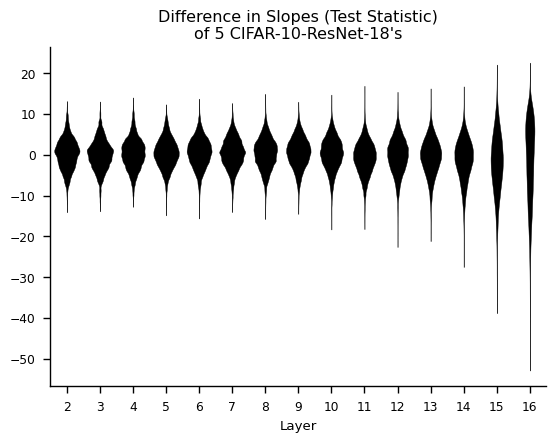

In [25]:
g = sns.violinplot(
    data=df_slope_diff_test_stat,
    x="Layer number", y="Slope Difference Test Statistic", color="black", inner=None, bw=0.1, linewidth=0.3
)
g.set_title("Difference in Slopes (Test Statistic)\nof 5 CIFAR-10-ResNet-18's", fontsize="large")
g.set(ylabel="", xlabel="Layer")
sns.despine()

### Show some examples

In [26]:
df_slope_diff_test_stat["Layer number"].unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [30]:
def plot_slopes(layeri, neuroni, classi, network, layer_offset=0):
    activations_dict_after, activations_dict_pre, logits, layers_after, layers_pre, labels, predicted_labels = load_activations_labels(network)

    binary_regressions = compute_binary_regressions(logits)
    
    print(f"Offsetting layer by {layer_offset}.")

    df_class_fr = produce_df_class_feature_relevance(activations_dict_after, layers_after, predicted_labels, logits, binary_regressions, layeri-layer_offset, neuroni, classi)

    slope_diff_ts = compute_slope_diff_test_statistic(df_class_fr)

    # sns.lmplot(x = "Activations", y = "Binary Logits", data=df_class_fr, style="In-Class", scatter_kws={'alpha':0.3}, color="black")

    f, ax = plt.subplots(figsize=(6, 6))

    scatter_kws={'alpha':0.3}
    ms = 15
    sns.regplot(ax=ax, x = "Activations", y = "Binary Logits", data=df_class_fr.query("`In-Class` == True"), color="black", scatter_kws=dict(s=ms, **scatter_kws), label="In-Class")
    sns.regplot(ax=ax, x = "Activations", y = "Binary Logits", data=df_class_fr.query("`In-Class` == False"), color="grey", scatter_kws=dict(s=ms/9, **scatter_kws), marker="s", label="Out-of-Class")

    leg = plt.legend(title="Samples", frameon=False)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
        lh.set_sizes([ms])
    
    ax = plt.gca()
    ax.set_title(f"Network {network}, Layer {layeri}, Neuron {neuroni}, Class {classi}:\nTest Statistic of {slope_diff_ts}", fontsize="large")
    sns.despine()
    return ax

Loading network with suffix: 5
Achieved accuracy of 0.9261
Binary logistic regression on class 0 gave a BAC of 0.9693516851539965.
Binary logistic regression on class 1 gave a BAC of 0.9889578280854128.
Binary logistic regression on class 2 gave a BAC of 0.9586752136752137.
Binary logistic regression on class 3 gave a BAC of 0.9480605811524909.
Binary logistic regression on class 4 gave a BAC of 0.9629519049087668.
Binary logistic regression on class 5 gave a BAC of 0.9587180432581581.
Binary logistic regression on class 6 gave a BAC of 0.9750650872627482.
Binary logistic regression on class 7 gave a BAC of 0.9796614111174855.
Binary logistic regression on class 8 gave a BAC of 0.9825468363379286.
Binary logistic regression on class 9 gave a BAC of 0.9806141324454309.
Offsetting layer by 2.


/tmp/ipykernel_2356918/1400410809.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.


<Axes: title={'center': 'Network 5, Layer 16, Neuron 415, Class 5:\nTest Statistic of 20.520992546277036'}, xlabel='Activations', ylabel='Binary Logits'>

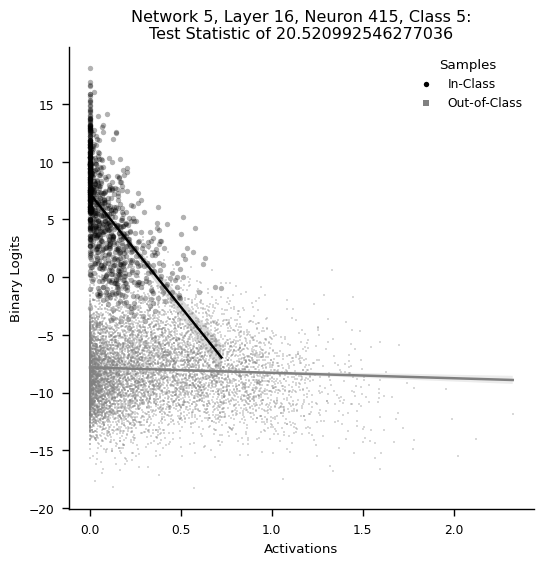

In [54]:
selected_row = df_slope_diff_test_stat.query("`Layer number` == 16").sort_values(by="Slope Difference Test Statistic", ascending=False).iloc[0]
plot_slopes(selected_row["Layer number"], selected_row["Neuron"], selected_row["Class"], selected_row["Network"], layer_offset=2)

Loading network with suffix: 3
Achieved accuracy of 0.9261
Binary logistic regression on class 0 gave a BAC of 0.965199519133598.
Binary logistic regression on class 1 gave a BAC of 0.988536175729101.
Binary logistic regression on class 2 gave a BAC of 0.9538815994388459.
Binary logistic regression on class 3 gave a BAC of 0.9463100607384831.
Binary logistic regression on class 4 gave a BAC of 0.965612230519938.
Binary logistic regression on class 5 gave a BAC of 0.958172786987711.
Binary logistic regression on class 6 gave a BAC of 0.9762401861006107.
Binary logistic regression on class 7 gave a BAC of 0.9719238773914727.
Binary logistic regression on class 8 gave a BAC of 0.9833548710412144.
Binary logistic regression on class 9 gave a BAC of 0.9805011345039264.
Offsetting layer by 2.


/tmp/ipykernel_2356918/1400410809.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.


<Axes: title={'center': 'Network 3, Layer 15, Neuron 56, Class 1:\nTest Statistic of 8.04008534735853'}, xlabel='Activations', ylabel='Binary Logits'>

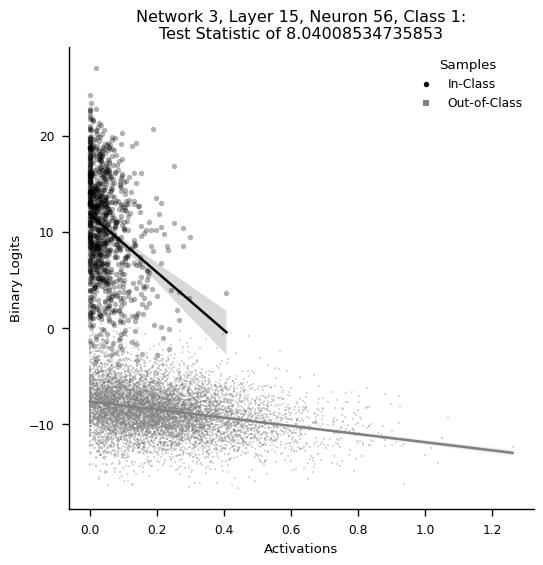

In [58]:
random_row = df_slope_diff_test_stat.iloc[np.random.randint(len(df_slope_diff_test_stat))]
plot_slopes(random_row["Layer number"], random_row["Neuron"], random_row["Class"], random_row["Network"], layer_offset=2)

What do these slopes mean?
In general: 
- negative slope means "inhibitory".
- positve slope means "excitatory"

But now I'm correcting for the being in that class.

If I flip around the difference to Out-of-Class - In-Class, then:
- positive means excitatory
- negative means inhibitory

Usually, I could just look at the out of class sample but also considering the In-class one helps to take perspective.
But should I really look at the difference? If both would be parallel, e.g. low slopes, then this would also be meaningful.

Well, if there is no slope difference, this means that this neuron doesn't really care for the class.

DONE: Why are the In-Class logits lower? Fixed.

Loading network with suffix: 1
Replacing network_suffix 1 with "".
Achieved accuracy of 0.9252
Binary logistic regression on class 0 gave a BAC of 0.9667510233008463.
Binary logistic regression on class 1 gave a BAC of 0.9857820170635508.
Binary logistic regression on class 2 gave a BAC of 0.9592765661848833.
Binary logistic regression on class 3 gave a BAC of 0.9395897302621659.
Binary logistic regression on class 4 gave a BAC of 0.969456230149861.
Binary logistic regression on class 5 gave a BAC of 0.9518007821537071.
Binary logistic regression on class 6 gave a BAC of 0.9786714398478589.
Binary logistic regression on class 7 gave a BAC of 0.9752721602448721.
Binary logistic regression on class 8 gave a BAC of 0.9831238132925936.
Binary logistic regression on class 9 gave a BAC of 0.9820076160971812.
Offsetting layer by 2.


/tmp/ipykernel_2149619/4171930023.py:21: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.


<Axes: title={'center': 'Network 1, Layer 8, Neuron 121, Class 1:\nTest Statistic of -15.022457721943404'}, xlabel='Activations', ylabel='Binary Logits'>

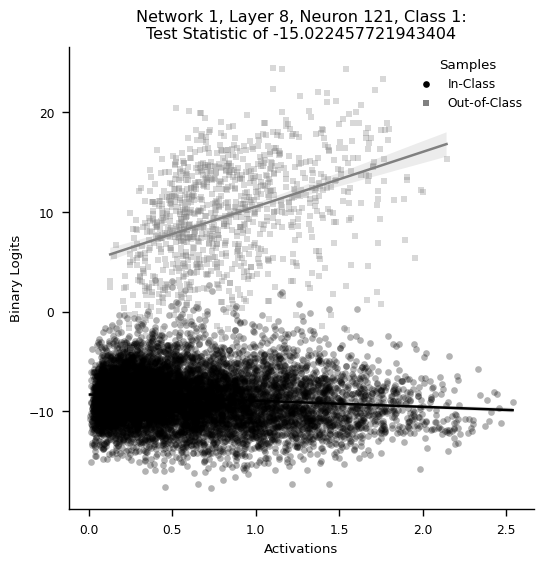

In [46]:
selected_row = df_slope_diff_test_stat.query("`Layer number` == 8").sort_values(by="Slope Difference Test Statistic", ascending=True).iloc[0]
plot_slopes(selected_row["Layer number"], selected_row["Neuron"], selected_row["Class"], selected_row["Network"], layer_offset=2)

Loading network with suffix: 4
Achieved accuracy of 0.9033
Binary logistic regression on class 0 gave a BAC of 0.9577770805140897.
Binary logistic regression on class 1 gave a BAC of 0.9842095178168948.
Binary logistic regression on class 2 gave a BAC of 0.9516741922579222.
Binary logistic regression on class 3 gave a BAC of 0.9217675526766436.
Binary logistic regression on class 4 gave a BAC of 0.9610617424684034.
Binary logistic regression on class 5 gave a BAC of 0.9451416455728416.


Binary logistic regression on class 6 gave a BAC of 0.9759696074784732.
Binary logistic regression on class 7 gave a BAC of 0.9745451877934272.
Binary logistic regression on class 8 gave a BAC of 0.9753586013241283.
Binary logistic regression on class 9 gave a BAC of 0.9729061161957226.
Offsetting layer by 2.


/tmp/ipykernel_2149619/4171930023.py:21: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.


<Axes: title={'center': 'Network 4, Layer 8, Neuron 102, Class 3:\nTest Statistic of 0.0007257832599533978'}, xlabel='Activations', ylabel='Binary Logits'>

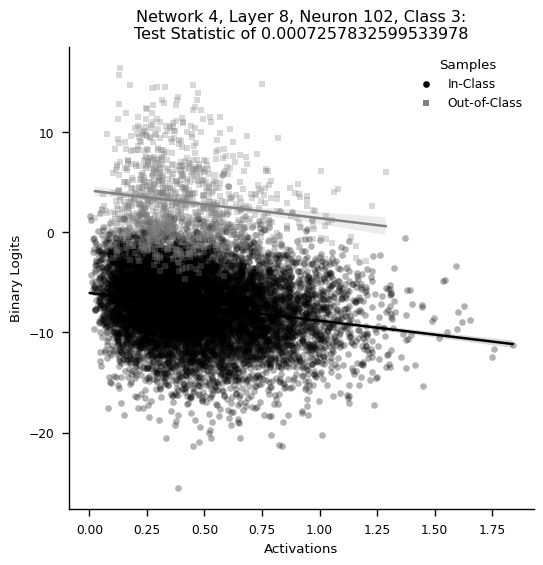

In [49]:
df_slope_diff_test_stat["Slope Difference Test Statistic (Abs.)"]= df_slope_diff_test_stat["Slope Difference Test Statistic"].abs()
selected_row = df_slope_diff_test_stat.query("`Layer number` == 8").sort_values(by="Slope Difference Test Statistic (Abs.)", ascending=True).iloc[0]
plot_slopes(selected_row["Layer number"], selected_row["Neuron"], selected_row["Class"], selected_row["Network"], layer_offset=2)

In [20]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [21]:
sample_df_class_fr = produce_df_class_feature_relevance(activations_dict_after, layers_after, predicted_labels, logits, binary_regressions, 3, 12, 4)
sample_df_class_fr

Probs.     Logits  Logits max.  Logits Difference  Activations   
0     0.923664  24.373697    24.373697           2.493214     0.481118  \
1     0.849823  25.733049    25.733049           1.733212     0.407068   
2     1.000000  36.945515    36.945515          22.542561     0.588940   
3     1.000000  30.343212    30.343212          18.764128     0.602007   
4     1.000000  24.389547    24.389547          20.965498     0.292604   
...        ...        ...          ...                ...          ...   
9995  1.000000  17.902981    17.902981         -26.936747     0.557225   
9996  1.000000  24.931564    24.931564         -39.657303     0.284381   
9997  1.000000  19.621107    19.621107         -29.717636     0.195910   
9998  1.000000  67.794579    67.794579         -84.885864     0.374133   
9999  1.000000  25.623310    25.623310         -36.398060     0.339543   

         Classes  In-Class           Domain  Binary Log. Probs.   
0     [0.0, 1.0]      True  Above threshold           -0.354109  \
1     [0.0, 1.0]      True  Above threshold           -0.151498   
2     [0.0, 1.0]      True  Above threshold           -0.001151   
3     [0.0, 1.0]      True  Above threshold           -0.007696   
4     [0.0, 1.0]      True  Above threshold           -0.106370   
...          ...       ...              ...                 ...   
9995  [1.0, 0.0]     False  Above threshold           -9.889236   
9996  [1.0, 0.0]     False  Above threshold          -15.855852   
9997  [1.0, 0.0]     False  Above threshold          -10.811954   
9998  [1.0, 0.0]     False  Above threshold          -11.345923   
9999  [1.0, 0.0]     False  Above threshold          -11.614592   

      Binary Probs.  Binary Logits  
0      7.017988e-01       0.855878  
1      8.594197e-01       1.810478  
2      9.988496e-01       6.766525  
3      9.923335e-01       4.863195  
4      8.990923e-01       2.187179  
...             ...            ...  
9995   5.071768e-05      -9.889185  
9996   1.299843e-07     -15.855852  
9997   2.015710e-05     -10.811934  
9998   1.181757e-05     -11.345911  
9999   9.033307e-06     -11.614583  

[10000 rows x 11 columns]

Loading network with suffix: 1
Replacing network_suffix 1 with "".
Achieved accuracy of 0.9252
Binary logistic regression on class 0 gave a BAC of 0.9667510233008463.
Binary logistic regression on class 1 gave a BAC of 0.9857820170635508.
Binary logistic regression on class 2 gave a BAC of 0.9592765661848833.
Binary logistic regression on class 3 gave a BAC of 0.9395897302621659.
Binary logistic regression on class 4 gave a BAC of 0.969456230149861.
Binary logistic regression on class 5 gave a BAC of 0.9518007821537071.
Binary logistic regression on class 6 gave a BAC of 0.9786714398478589.
Binary logistic regression on class 7 gave a BAC of 0.9752721602448721.
Binary logistic regression on class 8 gave a BAC of 0.9831238132925936.
Binary logistic regression on class 9 gave a BAC of 0.9820076160971812.
Offsetting layer by 0.


/tmp/ipykernel_2526529/1400410809.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.


<Axes: title={'center': 'Network 1, Layer 3, Neuron 12, Class 4:\nTest Statistic of -0.8205504464607712'}, xlabel='Activations', ylabel='Binary Logits'>

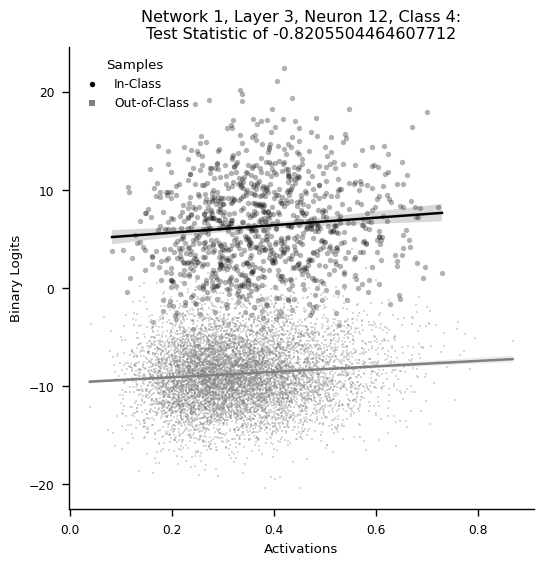

In [32]:
plot_slopes(3, 12, 4, 1, layer_offset=0)

In [26]:
mod = smf.ols(formula='Q("Binary Logits") ~ Activations + Q("In-Class")', data=sample_df_class_fr)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     Q("Binary Logits")   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     8799.
Date:                Fri, 08 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:55:48   Log-Likelihood:                -26370.
No. Observations:               10000   AIC:                         5.275e+04
Df Residuals:                    9997   BIC:                         5.277e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -9.69

How would that look like?

In [39]:
intercept_out_of_class = res.params["Intercept"]
intercept_in_class = res.params["Intercept"] + res.params['Q("In-Class")[T.True]']
slope = res.params["Activations"]

In [87]:
def my_error_bar(reg_pred_df):
    def error_bar(val):
        selected_row = reg_pred_df.query(f"Activations == {val}")
        return selected_row["mean_ci_lower"].item(), selected_row["mean_ci_upper"].item()
    return error_bar

/tmp/ipykernel_2526529/3408277550.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.


<Axes: xlabel='Activations', ylabel='Binary Logits'>

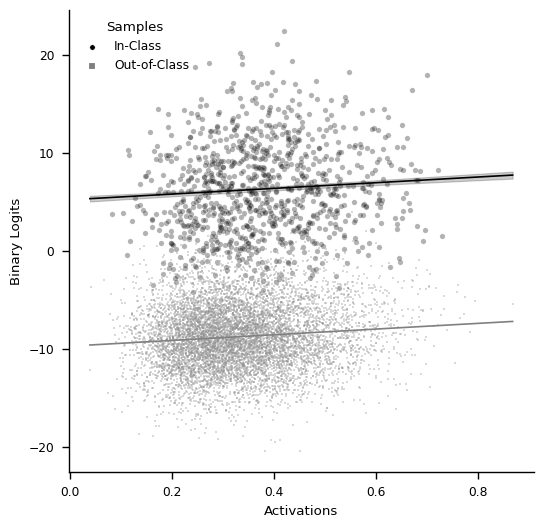

In [99]:
f, ax = plt.subplots(figsize=(6, 6))

scatter_kws={'alpha':0.3}
ms = 15
sns.scatterplot(ax=ax, x = "Activations", y = "Binary Logits", data=sample_df_class_fr.query("`In-Class` == True"), color="black", s=ms, **scatter_kws, label="In-Class")

x = np.linspace(sample_df_class_fr["Activations"].min(), sample_df_class_fr["Activations"].max(), 1000)
sample_df_class_fr_lin_reg_in_class = pd.DataFrame({"Activations": x, "In-Class": [True]*len(x)})
sample_df_class_fr_lin_reg_out_of_class = pd.DataFrame({"Activations": x, "In-Class": [False]*len(x)})

confidence = 0.05
pred_in_class = res.get_prediction(sample_df_class_fr_lin_reg_in_class).summary_frame(alpha=confidence)
pred_out_of_class = res.get_prediction(sample_df_class_fr_lin_reg_out_of_class).summary_frame(alpha=confidence)

reg_pred_in_class = pd.concat([sample_df_class_fr_lin_reg_in_class, pred_in_class], axis=1)

sns.lineplot(ax=ax, data=reg_pred_in_class, x = "Activations", y = "mean", color="black", errorbar=my_error_bar(reg_pred_in_class))

sns.scatterplot(ax=ax, x = "Activations", y = "Binary Logits", data=sample_df_class_fr.query("`In-Class` == False"), color="grey", s=ms/9, **scatter_kws, marker="s", label="Out-of-Class")

reg_pred_out_of_class = pd.concat([sample_df_class_fr_lin_reg_out_of_class, pred_out_of_class], axis=1)
sns.lineplot(ax=ax, data=reg_pred_out_of_class, x = "Activations", y = "mean", color="grey", errorbar=my_error_bar(reg_pred_out_of_class))

leg = plt.legend(title="Samples", frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([ms])

ax = plt.gca()
sns.despine()
ax

### Two Violin Plots based on pos. of neg. KS-D's

In [33]:
df_ks_cifar = load_ksd_dataframe_cifar10()
df_ks_cifar

Network  Layer  Neuron  Class  Kolmogorov-Smirnov Difference
0           1      2       0      0                       0.414763
1           1      2       0      1                      -0.104255
2           1      2       0      2                      -0.110735
3           1      2       0      3                       0.113709
4           1      2       0      4                      -0.235951
...       ...    ...     ...    ...                            ...
5115        5     16     511      5                       0.580093
5116        5     16     511      6                      -0.264001
5117        5     16     511      7                      -0.493300
5118        5     16     511      8                       0.634976
5119        5     16     511      9                       0.626802

[188800 rows x 5 columns]

In [34]:
df_slope_diff_test_stat_c = df_slope_diff_test_stat.copy()
df_slope_diff_test_stat_c["Layer"] = df_slope_diff_test_stat_c["Layer number"]
df_slope_kds_merged = pd.merge(df_slope_diff_test_stat_c, df_ks_cifar, on=["Network", "Layer", "Neuron", "Class"]).drop(columns=["Layer number", "Unnamed: 0"])


df_slope_kds_merged["Criterion"] = df_slope_kds_merged[KS_NAME].apply(lambda x: "KS-D's $< 0$" if x <= 0 else "KS-D's $\\geq 0$")
df_slope_kds_merged

Network  Layer  Neuron  Class  Slope Difference Test Statistic   
0             1      2       0      0                         4.608580  \
1             1      2       0      1                        -4.428365   
2             1      2       0      2                        -0.868398   
3             1      2       0      3                        -0.098681   
4             1      2       0      4                        -3.823553   
...         ...    ...     ...    ...                              ...   
188795        5     16     511      5                       -34.627023   
188796        5     16     511      6                        -5.755335   
188797        5     16     511      7                         6.870176   
188798        5     16     511      8                       -27.129898   
188799        5     16     511      9                       -20.070523   

        Kolmogorov-Smirnov Difference        Criterion  
0                            0.414763  KS-D's $\geq 0$  
1                           -0.104255     KS-D's $< 0$  
2                           -0.110735     KS-D's $< 0$  
3                            0.113709  KS-D's $\geq 0$  
4                           -0.235951     KS-D's $< 0$  
...                               ...              ...  
188795                       0.580093  KS-D's $\geq 0$  
188796                      -0.264001     KS-D's $< 0$  
188797                      -0.493300     KS-D's $< 0$  
188798                       0.634976  KS-D's $\geq 0$  
188799                       0.626802  KS-D's $\geq 0$  

[188800 rows x 7 columns]

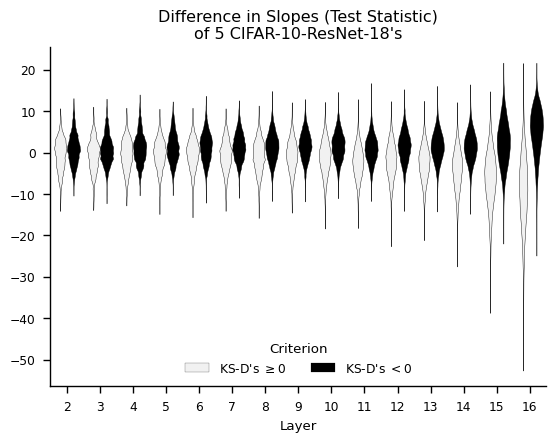

In [35]:
g = sns.violinplot(
    data=df_slope_kds_merged,
    x="Layer", y="Slope Difference Test Statistic", hue="Criterion", color="black", inner=None, bw=0.1, linewidth=0.3
)
g.set_title("Difference in Slopes (Test Statistic)\nof 5 CIFAR-10-ResNet-18's", fontsize="large")
g.set(ylabel="", xlabel="Layer")
g.legend(loc='lower center', title='Criterion', frameon=False, ncol=2)
sns.despine()

### TODO: check if this makes sense

# TODO: Regression Kink Analysis
Just compute to regressions without intercept to go through origin? Is that wanted? Probably not.

Check https://www.nber.org/system/files/working_papers/w22781/w22781.pdf for non-bayesian.

# Compute lin. regressions (correlation coefficient) of neuron acts vs. predicted class logits

I think this is just a worse approximation to a Jacobian. It's linearizing the remaining DNN using a simple correlation.

-0.10141887011515761

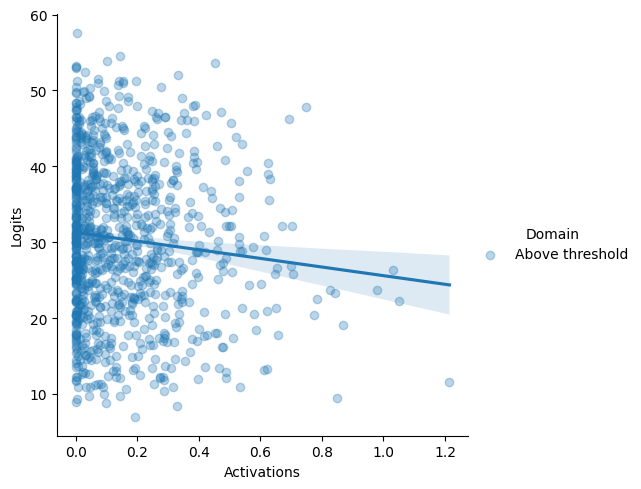

In [15]:
layeri, neuroni = 14, 21
classi = 2

df_class = produce_df_in_class(activations_dict_after, layers_after, predicted_labels_after, logits_after, layeri, neuroni, classi)

sns.lmplot(x = "Activations", y = "Logits", data=df_class, hue="Domain", scatter_kws={'alpha':0.3})

df_class[df_class['Activations'] > 0][['Activations', 'Logits']].corr().iloc[0, 1]

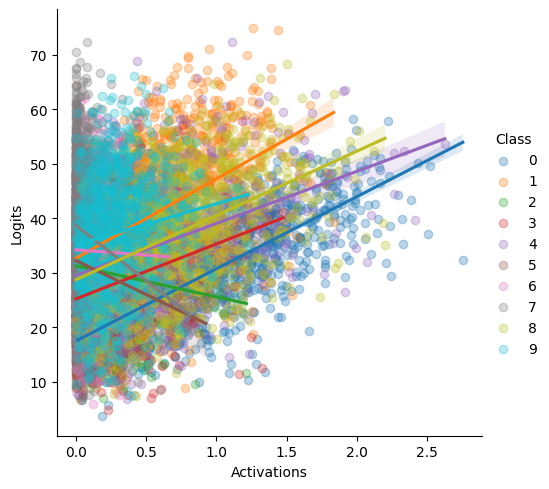

In [16]:
df_classes = []
for classi in np.unique(predicted_labels_after):
    df_class = produce_df_in_class(activations_dict_after, layers_after, predicted_labels_after, logits_after, layeri, neuroni, classi)
    df_class["Class"] = classi
    df_classes.append(df_class)

df_classes = pd.concat(df_classes)

sns.lmplot(x = "Activations", y = "Logits", data=df_classes, hue="Class", scatter_kws={'alpha':0.3})

In [17]:
df_classes[['Activations', 'Logits', 'Class']].groupby('Class').corr().iloc[::2, 1]

Class             
0      Activations    0.699921
1      Activations    0.405714
2      Activations   -0.098084
3      Activations    0.247200
4      Activations    0.364588
5      Activations   -0.125206
6      Activations   -0.019808
7      Activations   -0.180608
8      Activations    0.422697
9      Activations    0.138667
Name: Logits, dtype: float64

In [38]:
# layerx.0/1 is the same as in layers_bn, the relu1 ones are the same as bn1, because of manually applied relu
df_list = []
for network in ["", 2, 3, 4, 5]:
    activations_dict_after = np.load(f"{LOCAL_STORAGE}/activations_on_validation_averaged_spatial_bettercifar10single{network}_afterrelu.npy", allow_pickle=True).item()
    for layer in activations_dict_after.keys():
        if layer in ['logits', 'target_layer_names']:
            continue
        for neuroni in range(activations_dict_after[layer][0].shape[1]):
            for classi in range(10):
                layeri = layers_after.index(layer)
                df_class = produce_df_in_class(activations_dict_after, layers_after, predicted_labels_after, logits_after, layeri, neuroni, classi)

                corr = df_class[['Activations', 'Logits']].corr().iloc[0, 1]
                df = pd.DataFrame({'Network': 1 if network == "" else network, 'Layer': layer, "Neuron": neuroni, "Class": classi, "Correlation Class-Logits vs. Activations": corr}, index=[0])
                df_list.append(df)

df_corr_class_logits_acts = pd.concat(df_list)


In [39]:
df_corr_class_logits_acts.to_csv(f"{LOCAL_STORAGE}/correlation_class_logits_vs_activations_bettercifar10single_all.csv")

In [20]:
df_corr_class_logits_acts = pd.read_csv(f"{LOCAL_STORAGE}/correlation_class_logits_vs_activations_bettercifar10single_all.csv")
df_corr_class_logits_acts

df_corr_class_logits_acts["Layer Name"] = df_corr_class_logits_acts["Layer"]
df_corr_class_logits_acts["Layer"] = df_corr_class_logits_acts["Layer Name"].map(lambda x: layers_after.index(x) + 2)
df_corr_class_logits_acts
#layers_after
#df_corr_class_logits_acts[(df_corr_class_logits_acts['Neuron'] == 2) & (df_corr_class_logits_acts['Layer'] == layers_after[7]) & (df_corr_class_logits_acts['Network'] == 1)]

Unnamed: 0  Network  Layer  Neuron  Class   
0                0        1      2       0      0  \
1                0        1      2       0      1   
2                0        1      2       0      2   
3                0        1      2       0      3   
4                0        1      2       0      4   
...            ...      ...    ...     ...    ...   
188795           0        5     16     511      5   
188796           0        5     16     511      6   
188797           0        5     16     511      7   
188798           0        5     16     511      8   
188799           0        5     16     511      9   

        Correlation Class-Logits vs. Activations Layer Name  
0                                       0.137433   layer1.0  
1                                       0.095930   layer1.0  
2                                      -0.006508   layer1.0  
3                                       0.020019   layer1.0  
4                                       0.005546   layer1.0  
...                                          ...        ...  
188795                                  0.587587   layer4.1  
188796                                  0.138894   layer4.1  
188797                                 -0.258645   layer4.1  
188798                                  0.572066   layer4.1  
188799                                  0.482071   layer4.1  

[188800 rows x 7 columns]

### Compare with KS-D

In [98]:
df_ks_cifar = load_ksd_dataframe_cifar10()
df_ks_cifar

Network  Layer  Neuron  Class  Kolmogorov-Smirnov Difference
0           1      2       0      0                       0.414763
1           1      2       0      1                      -0.104255
2           1      2       0      2                      -0.110735
3           1      2       0      3                       0.113709
4           1      2       0      4                      -0.235951
...       ...    ...     ...    ...                            ...
5115        5     16     511      5                       0.580093
5116        5     16     511      6                      -0.264001
5117        5     16     511      7                      -0.493300
5118        5     16     511      8                       0.634976
5119        5     16     511      9                       0.626802

[188800 rows x 5 columns]

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child8), but could not find a label for it.


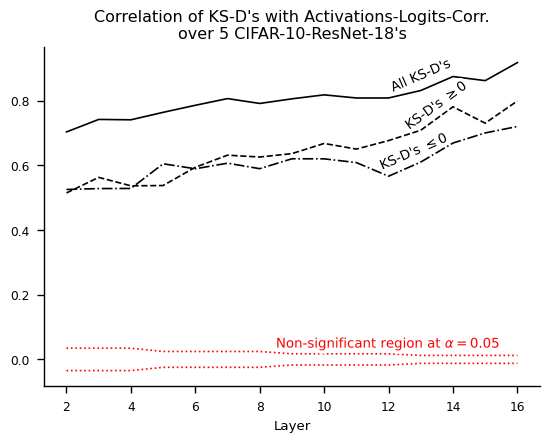

In [55]:
df_corr_whole_layer = pd.merge(df_ks_cifar, df_corr_class_logits_acts, on=["Network", "Layer", "Neuron", "Class"]).groupby(["Layer"])[[KS_NAME, "Correlation Class-Logits vs. Activations"]].corr().iloc[0::2, -1].reset_index().rename(columns={'Correlation Class-Logits vs. Activations': 'Correlation KS-D with Activations-Logits-Corr.'})
df_corr_whole_layer["Criterion"] = "All KS-D's"

df_ks_cifar_pos = df_ks_cifar[df_ks_cifar[KS_NAME] >= 0]
df_ks_cifar_neg = df_ks_cifar[df_ks_cifar[KS_NAME] <= 0]

df_corr_whole_layer_ks_pos = pd.merge(df_ks_cifar_pos, df_corr_class_logits_acts, on=["Network", "Layer", 'Neuron', "Class"]).sort_values(by=['Network', 'Neuron', 'Class']).groupby(["Layer"])[[KS_NAME, "Correlation Class-Logits vs. Activations"]].corr().iloc[0::2,-1].reset_index().rename(columns={'Correlation Class-Logits vs. Activations': 'Correlation KS-D with Activations-Logits-Corr.'})
df_corr_whole_layer_ks_pos['Criterion'] = "KS-D's $\\geq 0$"

df_corr_whole_layer_ks_neg = pd.merge(df_ks_cifar_neg, df_corr_class_logits_acts, on=["Network", "Layer", 'Neuron', "Class"]).sort_values(by=['Network', 'Neuron', 'Class']).groupby(["Layer"])[[KS_NAME, "Correlation Class-Logits vs. Activations"]].corr().iloc[0::2,-1].reset_index().rename(columns={'Correlation Class-Logits vs. Activations': 'Correlation KS-D with Activations-Logits-Corr.'})
df_corr_whole_layer_ks_neg['Criterion'] = "KS-D's $\\leq 0$"

df_corr_whole_all = pd.concat([df_corr_whole_layer, df_corr_whole_layer_ks_pos, df_corr_whole_layer_ks_neg])

# Critical values for the correlation
def r_crit_abs(n, p=0.05):
    dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
    r_crit_abs = -dist.ppf(p/2)
    return r_crit_abs

df_r_crit = pd.merge(df_ks_cifar, df_corr_class_logits_acts, on=["Network", "Layer", 'Neuron', "Class"]).groupby(["Layer"]).count()['Neuron'].reset_index().rename(columns={'Neuron': 'n'})
df_r_crit['Correlation KS-D with Activations-Logits-Corr.'] = df_r_crit['n'].apply(lambda n: r_crit_abs(n))
df_r_crit['Criterion'] = 'Non-significant region at $\\alpha = 0.05$'
df_r_crit = df_r_crit.drop(columns=['n'])
df_r_crit

df_r_crit_neg = df_r_crit.copy()
df_r_crit_neg['Criterion'] = ''
df_r_crit_neg['Correlation KS-D with Activations-Logits-Corr.'] = -df_r_crit_neg['Correlation KS-D with Activations-Logits-Corr.']

df_corr_whole_all = df_corr_whole_all.drop(columns=['level_1'])
df_corr_whole_all = pd.concat([df_corr_whole_all, df_r_crit, df_r_crit_neg])

crits = df_corr_whole_all['Criterion'].unique()
styles = ['solid', 'dashed', 'dashdot', 'dotted', 'dotted']
colors = ['black', 'black', 'black', 'red', 'red']

for c, s, col in zip(crits, styles, colors):
    sns.lineplot(data=df_corr_whole_all[df_corr_whole_all['Criterion'] == c], x='Layer', y='Correlation KS-D with Activations-Logits-Corr.', linestyle=s, color=col, legend=False, label=c)
l = plt.gca().get_lines()

# df_r_crit_fb = df_corr_whole_all[(df_corr_whole_all['Criterion'].str.contains('Critical')) & (df_corr_whole_all['Network'] == 1)]
# plt.gca().fill_between(df_r_crit_fb['Layer'], -df_r_crit_fb['Correlation KS-D with Avg. Jac.'], df_r_crit_fb['Correlation KS-D with Avg. Jac.'], label='Region')

labelLines(l, align=[True, True, True, False], xvals=[13, 13.5, 12.8, 12], yoffsets=[0.045, 0.04, 0.04, 0.03]);
# custom_lines = [Line2D([0], [0], color="black", lw=1.5, linestyle=l[0].get_linestyle()),
#                 Line2D([0], [0], color="black", lw=1.5, linestyle=l[1].get_linestyle()),
#                 Line2D([0], [0], color="black", lw=1.5, linestyle=l[2].get_linestyle()),
#                 ]
# plt.gca().legend(custom_lines, crits, ncols=2, loc=loc, frameon=False, title="Criterion")
plt.gca().set(ylabel='')
plt.gca().set_title("Correlation of KS-D's with Activations-Logits-Corr.\nover 5 CIFAR-10-ResNet-18's", fontsize='large')
sns.despine()


# Checking stuff again

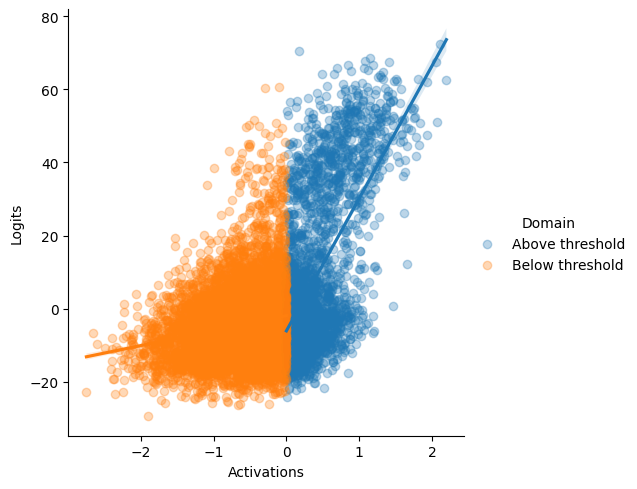

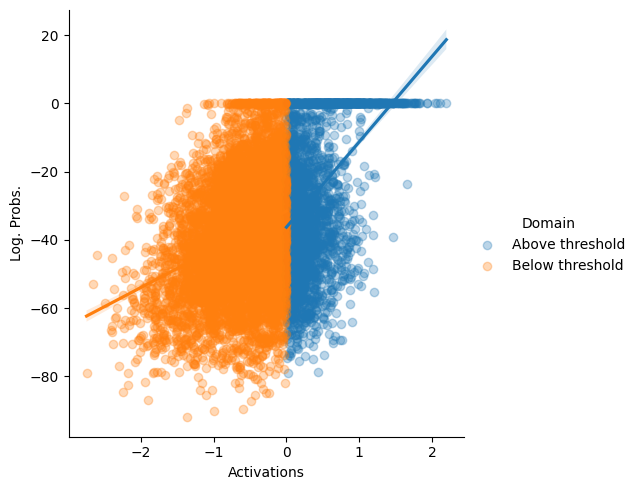

In [134]:
# for _ in range(10):
layeri, neuroni = 7, np.random.randint(512)
classi = np.random.randint(10)

layer_pre = layers_pre[layeri]
if 'relu2' in layer_pre:
    target_layer = layer_pre.replace(".relu2", "")
else:
    target_layer = layer_pre
# after_layeri = layers_after.index(target_layer)
after_layeri = -3

df_class_pre = produce_df_class_logits(activations_dict_pre, layers_pre, logits_pre, layeri, neuroni, classi)
sns.lmplot(x = "Activations", y = "Logits", data=df_class_pre, hue="Domain", scatter_kws={'alpha':0.3})
sns.lmplot(x = "Activations", y = "Log. Probs.", data=df_class_pre, hue="Domain", scatter_kws={'alpha':0.3})

# df_class_after = produce_df_class_logits(activations_dict_after, layers_after, logits_pre, after_layeri, neuroni, classi)
# sns.lmplot(x = "Activations", y = "Logits", data=df_class_after, hue="Domain", scatter_kws={'alpha':0.3})
# sns.lmplot(x = "Activations", y = "Log. Probs.", data=df_class_after, hue="Domain", scatter_kws={'alpha':0.3})

# TODO: Something is wrong here
# df_class_pre['From'] = 'Pre-Relu'
# df_class_after['From'] = 'After-Relu'
# df_class_both = pd.concat([df_class_pre, df_class_after])
# sns.lmplot(x = "Activations", y = "Logits", data=df_class_both, hue="From", scatter_kws={'alpha':0.3})

Focus on logits!

In [130]:
df_class_after

Probs.     Logits  Log. Probs.  Activations           Domain   
0     2.372137e-32  -7.695069   -72.818932     0.366387  Above threshold  \
1     2.601902e-20  -5.082828   -45.095459     0.407184  Above threshold   
2     2.073680e-09  -0.394582   -19.993940     0.049063  Above threshold   
3     1.500678e-25 -10.461564   -57.158710     0.427066  Above threshold   
4     7.068010e-04   9.170366    -7.254761     0.262850  Above threshold   
...            ...        ...          ...          ...              ...   
9995  1.993114e-12  -9.033766   -26.941322     0.294481  Above threshold   
9996  5.876555e-18 -14.725740   -39.675560     0.039101  Above threshold   
9997  1.229737e-13 -10.096528   -29.726807     0.468028  Above threshold   
9998  1.363131e-37 -17.091284   -84.885864     0.185733  Above threshold   
9999  1.553642e-16 -10.774750   -36.400761     0.384058  Above threshold   

            From  
0     After-Relu  
1     After-Relu  
2     After-Relu  
3     After-Relu  
4     After-Relu  
...          ...  
9995  After-Relu  
9996  After-Relu  
9997  After-Relu  
9998  After-Relu  
9999  After-Relu  

[10000 rows x 6 columns]

# Linear Regression Experiments - Rather use Feature Relevance than max-predicted logit for relevance.

What have I really computed here?

For activations vs. logits of samples of a class: Does not mean too much!

I should consider all samples and their logits for that class.


For activations vs. max logits of all samples: This is more like if a neuron is in general inhibitory or excitatory.

## Load regressions

In [34]:
# OLD, and unnecessary to compute, see comment in the corresponding section
# est_regression_df_pos_acts_class_true = pd.read_csv("local_storage/cifar10_est_regression_df_pos_acts_class_true_afterrelu.csv")
# est_regression_df_full_acts_class_true = pd.read_csv("local_storage/cifar10_est_regression_df_full_acts_class_true_afterrelu.csv")
# est_regression_df_pos_acts_class_predicted = pd.read_csv("local_storage/cifar10_est_regression_df_pos_acts_class_predicted_afterrelu.csv")
# est_regression_df_full_acts_class_predicted = pd.read_csv("local_storage/cifar10_est_regression_df_full_acts_class_predicted_afterrelu.csv")

est_regression_df_pos_acts_class_logits = pd.read_csv("local_storage/cifar10_est_regression_df_pos_acts_class_logits_afterrelu.csv")
est_regression_df_full_acts_class_logits = pd.read_csv("local_storage/cifar10_est_regression_df_full_acts_class_logits_afterrelu.csv")

est_regression_df_pos_acts_max_class = pd.read_csv("local_storage/cifar10_est_regression_df_pos_acts_max_class_afterrelu.csv")
est_regression_df_full_acts_max_class = pd.read_csv("local_storage/cifar10_est_regression_df_full_acts_max_class_afterrelu.csv")

In [35]:
significant_estimates = est_regression_df_pos_acts_class_logits[est_regression_df_pos_acts_class_logits["Estimate significant (alpha=0.05)"]]
(significant_estimates["Estimate"] < 0).sum()/len(significant_estimates), (significant_estimates["Estimate"] > 0).sum()/len(significant_estimates)
significant_estimates['Class'] = pd.Categorical(significant_estimates['Class'])

/tmp/ipykernel_13689/2911821969.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [36]:
est_regression_df_pos_acts_class_logits

Unnamed: 0  Layer Layername  Neuron  Class  Estimate  Estimate Std.   
0               0      0  layer1.0       0      0  0.269276       0.007238  \
1               1      0  layer1.0       0      1 -0.022343       0.007689   
2               2      0  layer1.0       0      2 -0.042385       0.007430   
3               3      0  layer1.0       0      3  0.000907       0.007688   
4               4      0  layer1.0       0      4 -0.118548       0.007463   
...           ...    ...       ...     ...    ...       ...            ...   
37855       37855     15    logits       9      5 -0.000981       0.000138   
37856       37856     15    logits       9      6 -0.001213       0.000162   
37857       37857     15    logits       9      7 -0.001693       0.000186   
37858       37858     15    logits       9      8 -0.006797       0.000388   
37859       37859     15    logits       9      9  0.024975       0.000240   

       Estimate pvalue  Estimate significant (alpha=0.05)  Intercept   
0        7.997190e-284                               True  -0.133005  \
1         3.670454e-03                               True   0.120248   
2         1.200924e-08                               True   0.132952   
3         9.060864e-01                              False   0.103696   
4         3.920161e-56                               True   0.201804   
...                ...                                ...        ...   
37855     1.622741e-12                               True   0.033830   
37856     7.783742e-14                               True   0.043634   
37857     1.522892e-19                               True   0.060045   
37858     6.169078e-66                               True   0.281671   
37859     0.000000e+00                               True  -0.117499   

       Intercept Std.  Intercept pvalue  Intercept significant (alpha=0.05)   
0            0.006930      1.188346e-80                                True  \
1            0.007361      3.253001e-59                                True   
2            0.007114      1.201874e-76                                True   
3            0.007360      1.196471e-44                                True   
4            0.007145     6.418733e-169                                True   
...               ...               ...                                 ...   
37855        0.003123      6.385897e-27                                True   
37856        0.003651      2.647415e-32                                True   
37857        0.004202      4.549158e-45                                True   
37858        0.008759     5.422657e-199                                True   
37859        0.005428      1.223597e-97                                True   

       R-squared  
0       0.121590  
1       0.000844  
2       0.003244  
3       0.000001  
4       0.024616  
...          ...  
37855   0.014164  
37856   0.015844  
37857   0.023111  
37858   0.080666  
37859   0.755253  

[37860 rows x 14 columns]

/tmp/ipykernel_13689/3050289125.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator


<Axes: xlabel='Layername', ylabel='Estimate'>

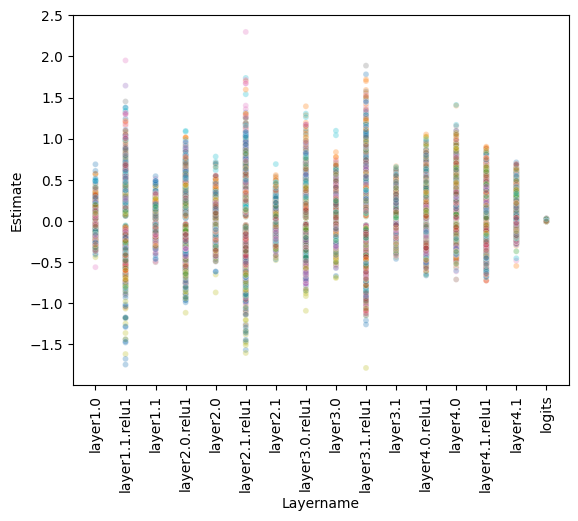

In [37]:
# plot the coefficients as scatter over layers
p = sns.scatterplot(data=significant_estimates, x="Layername", y="Estimate", hue="Class", alpha=0.3, size=0.1)
p.set_xticklabels(p.get_xticklabels(), rotation=90)
p.legend_.remove()
p

/tmp/ipykernel_13689/4100653100.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator


<Axes: xlabel='Layername', ylabel='Estimate'>

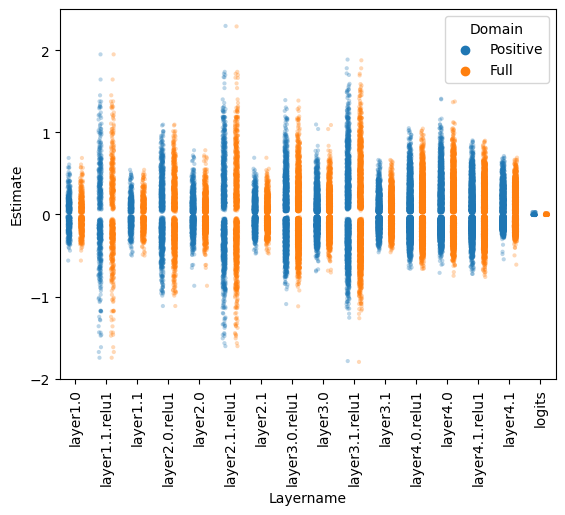

In [38]:
# compare the full and pos. coeffs, this should check for a threshold effect... is this related to the regression kink design?
# Not much difference, which makes sense

est_regression_df_pos_acts_class_logits['Domain'] = 'Positive'
est_regression_df_full_acts_class_logits['Domain'] = 'Full'
joined_df = pd.concat([est_regression_df_pos_acts_class_logits, est_regression_df_full_acts_class_logits])
significant_estimates_joined = joined_df[joined_df["Estimate significant (alpha=0.05)"]]

p = sns.stripplot(data=significant_estimates_joined, x="Layername", y="Estimate", hue="Domain", dodge=True, jitter=True, alpha=0.3, size=3)
p.set_xticklabels(p.get_xticklabels(), rotation=90)
p

In [19]:
# Correlation? Super high.
np.corrcoef(est_regression_df_pos_acts_class_logits["Estimate"], est_regression_df_full_acts_class_logits["Estimate"])

array([[1.        , 0.99811981],
       [0.99811981, 1.        ]])

### Plot neuron with low coeff.

In [40]:
significant_estimates.loc[significant_estimates["Estimate"] < -1.75]

Unnamed: 0  Layer       Layername  Neuron Class  Estimate   
12778       12778      9  layer3.1.relu1      61     8 -1.786071  \

       Estimate Std.  Estimate pvalue  Estimate significant (alpha=0.05)   
12778       0.054478    5.384616e-224                               True  \

       Intercept  Intercept Std.  Intercept pvalue   
12778   0.273552        0.005989               0.0  \

       Intercept significant (alpha=0.05)  R-squared  
12778                                True   0.097168

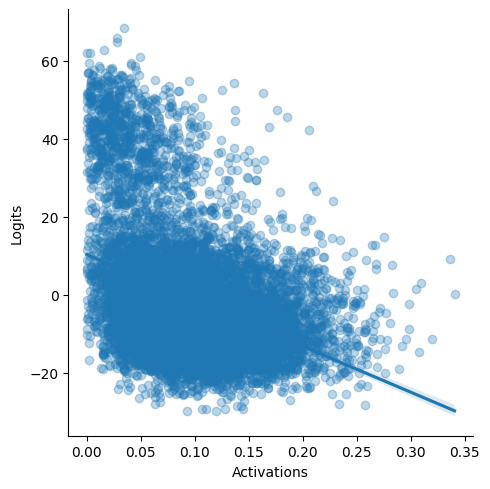

In [41]:
layeri, neuroni, classi = 9, 61, 8
df_neuron = produce_df_class_logits(activations_dict, layers, logits, layeri, neuroni, classi)
df_neuron = df_neuron.loc[df_neuron['Activations'] >= 0] 
sns.lmplot(data=df_neuron, x='Activations', y='Logits', scatter_kws={"alpha":0.3})
# df_neuron['Logits']

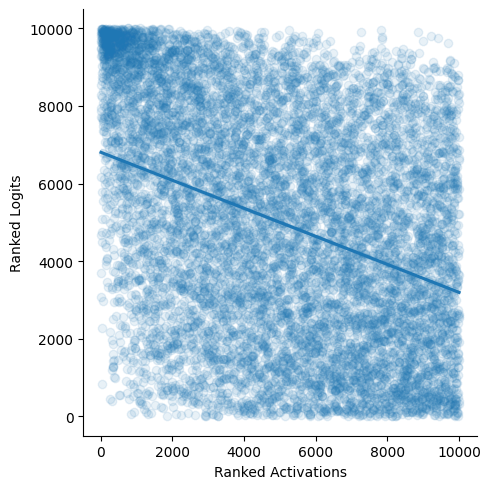

In [48]:
#DONE: rank plot
df_neuron["Ranked Activations"] = df_neuron["Activations"].rank()
df_neuron["Ranked Logits"] = df_neuron["Logits"].rank()
sns.lmplot(data=df_neuron, x='Ranked Activations', y='Ranked Logits', scatter_kws={"alpha":0.1})
# sns.scatterplot(data=df_neuron, x='Ranked Activations', y='Ranked Logits', alpha=0.1)

In [20]:
# Irrelevant, because not useful

# # compare true and predicted labels
# # smaller spread for predicted... less noisy makes sense

# est_regression_df_pos_acts_class_true['Labels'] = 'True'
# est_regression_df_pos_acts_class_predicted['Labels'] = 'Predicted'
# joined_df = pd.concat([est_regression_df_pos_acts_class_true, est_regression_df_pos_acts_class_predicted])
# significant_estimates_joined = joined_df[joined_df["Estimate significant (alpha=0.05)"]]

# p = sns.stripplot(data=significant_estimates_joined, x="Layername", y="Estimate", hue="Labels", dodge=True, jitter=True, alpha=0.3, size=3)
# p.set_xticklabels(p.get_xticklabels(), rotation=30)
# p

## Maximum predicted class

/tmp/ipykernel_13689/2422117746.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator


<Axes: xlabel='Layername', ylabel='Estimate'>

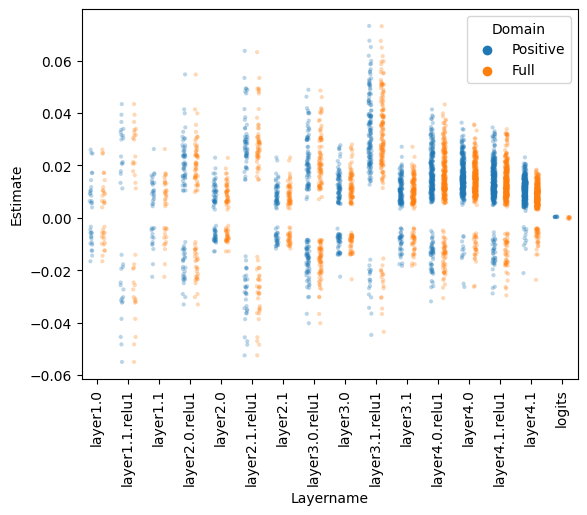

In [21]:
# compare true and predicted labels
# smaller spread for predicted... less noisy makes sense

est_regression_df_pos_acts_max_class['Domain'] = "Positive"
est_regression_df_full_acts_max_class['Domain'] = "Full"
joined_df = pd.concat([est_regression_df_pos_acts_max_class, est_regression_df_full_acts_max_class])
significant_estimates = joined_df[joined_df["Estimate significant (alpha=0.05)"]]

p = sns.stripplot(data=significant_estimates, x="Layername", y="Estimate", hue='Domain', alpha=0.3, size=3, dodge=True, jitter=True)
p.set_xticklabels(p.get_xticklabels(), rotation=90)
p

### How many are significant?

In [22]:
joined_df["Estimate significant (alpha=0.05)"].sum()/len(joined_df)

0.626122556788167

In [23]:
# numbers per layer that are above or below zero
significant_estimates["Estimate < 0"] = significant_estimates["Estimate"] < 0
significant_estimates["Estimate >= 0"] = significant_estimates["Estimate"] > 0
counts_negative_coeff_df = pd.DataFrame(significant_estimates.groupby("Layername")["Estimate < 0"].sum())
counts_positive_coeff_df = pd.DataFrame(significant_estimates.groupby("Layername")["Estimate >= 0"].sum())
counts_negative_coeff_df = counts_negative_coeff_df.rename(columns={"Estimate < 0": "Counts"})
counts_negative_coeff_df["Type"] = "Estimate < 0"
counts_positive_coeff_df = counts_positive_coeff_df.rename(columns={"Estimate >= 0": "Counts"})
counts_positive_coeff_df["Type"] = "Estimate >= 0"

counts_df = pd.concat([counts_negative_coeff_df, counts_positive_coeff_df]).reset_index()
counts_df

/tmp/ipykernel_13689/82020269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_13689/82020269.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Layername  Counts           Type
0         layer1.0      30   Estimate < 0
1         layer1.1      26   Estimate < 0
2   layer1.1.relu1      32   Estimate < 0
3         layer2.0      56   Estimate < 0
4   layer2.0.relu1      56   Estimate < 0
5         layer2.1      52   Estimate < 0
6   layer2.1.relu1      60   Estimate < 0
7         layer3.0      77   Estimate < 0
8   layer3.0.relu1     124   Estimate < 0
9         layer3.1      68   Estimate < 0
10  layer3.1.relu1      34   Estimate < 0
11        layer4.0      39   Estimate < 0
12  layer4.0.relu1      98   Estimate < 0
13        layer4.1      44   Estimate < 0
14  layer4.1.relu1      78   Estimate < 0
15          logits       4   Estimate < 0
16        layer1.0      34  Estimate >= 0
17        layer1.1      44  Estimate >= 0
18  layer1.1.relu1      36  Estimate >= 0
19        layer2.0      82  Estimate >= 0
20  layer2.0.relu1     100  Estimate >= 0
21        layer2.1      96  Estimate >= 0
22  layer2.1.relu1     104  Estimate >= 0
23        layer3.0     148  Estimate >= 0
24  layer3.0.relu1     155  Estimate >= 0
25        layer3.1     240  Estimate >= 0
26  layer3.1.relu1     259  Estimate >= 0
27        layer4.0     603  Estimate >= 0
28  layer4.0.relu1     474  Estimate >= 0
29        layer4.1     768  Estimate >= 0
30  layer4.1.relu1     707  Estimate >= 0
31          logits      13  Estimate >= 0

<Axes: xlabel='Layername', ylabel='Counts'>

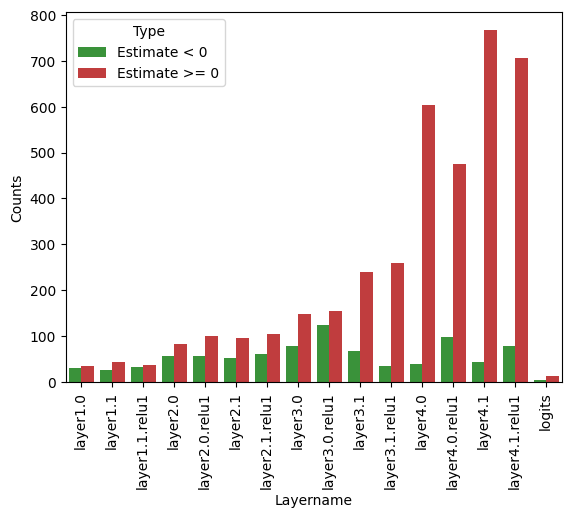

In [24]:
palette = {"Estimate < 0": "C2", "Estimate >= 0": "C3"}

p = sns.barplot(data=counts_df, x="Layername", y="Counts", hue="Type", palette=palette)
p.set_xticklabels(p.get_xticklabels(), rotation=90)
p

Fewer inhibitory neurons, especially for later layers. But, earlier layers could just fit worse with lin. regression.

/tmp/ipykernel_13689/3268625740.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_13689/3268625740.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator


<Axes: xlabel='Layername', ylabel='R-squared'>

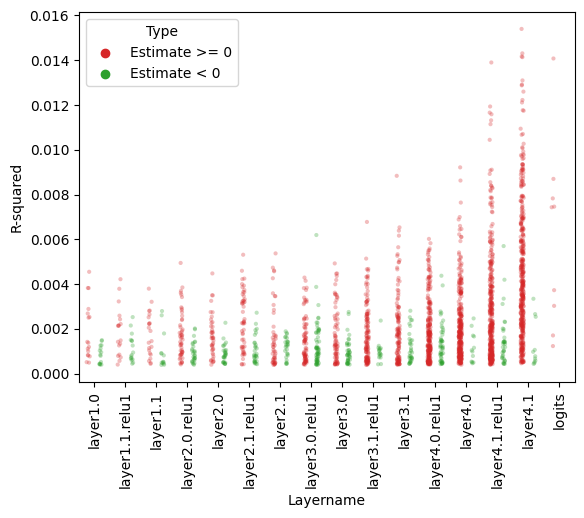

In [25]:
df = significant_estimates.loc[significant_estimates["Domain"] == "Positive"]
df["Type"] = df["Estimate < 0"].apply(lambda x: "Estimate < 0" if x else "Estimate >= 0")

palette = {"Estimate < 0": "C2", "Estimate >= 0": "C3"}

p = sns.stripplot(data=df, x="Layername", y="R-squared", hue='Type', alpha=0.3, size=3, dodge=True, jitter=True, palette=palette)
p.set_xticklabels(p.get_xticklabels(), rotation=90)
p

Yep, the linear regression is worse for earlier layers and worse for negative estimates.

### Plot a neuron with a low coeff.

In [30]:
significant_estimates.loc[significant_estimates["Estimate"] < -0.05]

Unnamed: 0  Layer       Layername  Neuron  Estimate  Estimate Std.   
125         125      1  layer1.1.relu1      61 -0.055010       0.011866  \
548         548      5  layer2.1.relu1     100 -0.052515       0.010061   
125         125      1  layer1.1.relu1      61 -0.055010       0.011866   
548         548      5  layer2.1.relu1     100 -0.052515       0.010061   

     Estimate pvalue  Estimate significant (alpha=0.05)  Intercept   
125     3.596437e-06                               True   0.991496  \
548     1.829348e-07                               True   0.991017   
125     3.596437e-06                               True   0.991496   
548     1.829348e-07                               True   0.991017   

     Intercept Std.  Intercept pvalue  Intercept significant (alpha=0.05)   
125        0.001774               0.0                                True  \
548        0.001524               0.0                                True   
125        0.001774               0.0                                True   
548        0.001524               0.0                                True   

     R-squared    Domain  Estimate < 0  Estimate >= 0  
125   0.002145  Positive          True          False  
548   0.002718  Positive          True          False  
125   0.002145      Full          True          False  
548   0.002718      Full          True          False

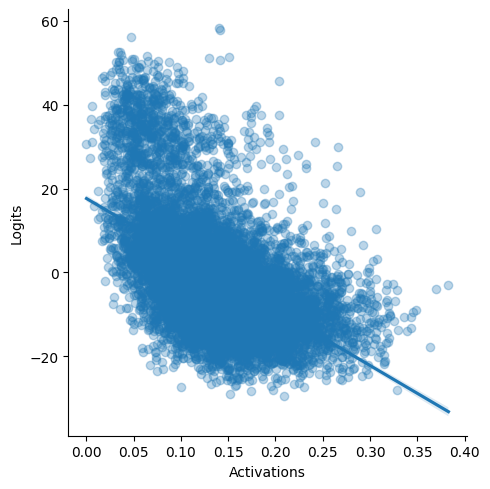

In [33]:
layeri, neuroni = 1, 61
df_neuron = produce_df_max_class(activations_dict, layers, logits, layeri, neuroni)
df_neuron = df_neuron.loc[df_neuron['Activations'] >= 0] 
sns.lmplot(data=df_neuron, x='Activations', y='Logits', scatter_kws={"alpha":0.3})
# df_neuron['Logits']

## Solved: What about the intercepts? Ignore them.

If they are already quite high, then a coeff. of zero still means that the class is predicted..

But I still think it should be ignored. We care about: the bigger, the better?

# Feature relevance experiments by Reimers

- Check this again and use it to compare the KS-D pos. and KS-D negative
- Pre and after ReLU relevance could answer something about the effect of the threshold.
    - This is conditioning away the class information. Therefore, it's about the effect coming from the neuron itself. Comparing pre and after ReLU could answer if some "power" is lost by the thresholding and if KS-D neg. or positive are more or less affected by that.

Partial correlation or RCOT of activations with class logits conditioned on the class. 

In [57]:
fr_type = "RCOT"

if fr_type == "pcorr":
    on_name = "Logits".replace(".", "")
    
    # (linear) partial correlation
    est_fr_pos = pd.read_csv(f"local_storage/cifar10_pcorr_{on_name}_estimates_pos_afterrelu.csv")
    est_fr_full = pd.read_csv(f"local_storage/cifar10_pcorr_{on_name}_estimates_full_afterrelu.csv")
elif fr_type == "RCOT":
    print("RCOT is always positive. There is no directional information in nonlinear correlation.")

    # (nonlinear) RCOT
    est_fr_pos = pd.read_csv("local_storage/cifar10_rcot_estimates_pos_prerelu.csv")
    est_fr_full = pd.read_csv("local_storage/cifar10_rcot_estimates_full_prerelu.csv")
else:
    raise Exception(f"Invalid fr_type: {fr_type}")

RCOT is always positive. There is no directional information in nonlinear correlation.


In [58]:
significant_est_fr_pos = est_fr_pos.loc[est_fr_pos["Estimate significant (alpha=0.05)"]]
significant_est_fr_full = est_fr_full.loc[est_fr_full["Estimate significant (alpha=0.05)"]]

In [63]:
est_fr_full

Unnamed: 0  Layer       Layername  Neuron  Class     Estimate   
0               0      0  layer1.0.relu2       0      0    71.281122  \
1               1      0  layer1.0.relu2       0      1    34.628851   
2               2      0  layer1.0.relu2       0      2    41.737244   
3               3      0  layer1.0.relu2       0      3    31.979896   
4               4      0  layer1.0.relu2       0      4    70.516174   
...           ...    ...             ...     ...    ...          ...   
19295       19295      8          logits       9      5   291.453981   
19296       19296      8          logits       9      6   379.184821   
19297       19297      8          logits       9      7   305.194083   
19298       19298      8          logits       9      8   476.366274   
19299       19299      8          logits       9      9  1718.836198   

       Estimate pvalue  Estimate significant (alpha=0.05)  
0             0.003420                               True  
1             0.095873                              False  
2             0.126761                              False  
3             0.203905                              False  
4             0.000248                               True  
...                ...                                ...  
19295         0.000000                               True  
19296         0.000000                               True  
19297         0.000000                               True  
19298         0.000000                               True  
19299         0.000000                               True  

[19300 rows x 8 columns]

In [59]:
significant_est_fr_pos["Class"] = pd.Categorical(significant_est_fr_pos["Class"])
significant_est_fr_full["Class"] = pd.Categorical(significant_est_fr_full["Class"])

/tmp/ipykernel_2530274/3205970414.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_2530274/3205970414.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/tmp/ipykernel_2530274/3273398443.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator


<Axes: xlabel='Layername', ylabel='Estimate'>

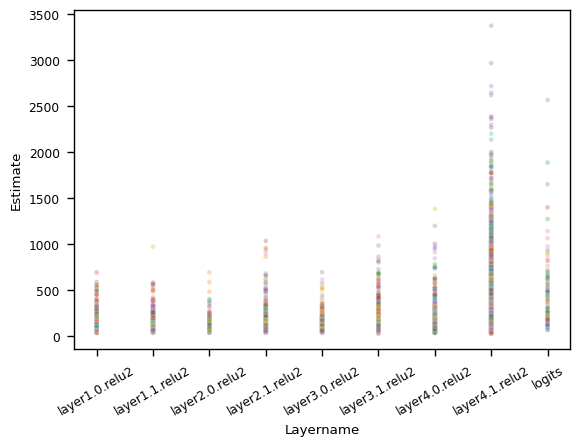

In [60]:
p = sns.scatterplot(data=significant_est_fr_pos, x="Layername", y="Estimate", hue="Class", alpha=0.3, size=0.1)
p.set_xticklabels(p.get_xticklabels(), rotation=30)
p.legend_.remove()
p

In [61]:
significant_est_fr_pos['Domain'] = "after ReLU"
significant_est_fr_full['Domain'] = "pre ReLU"
significant_est_fr_both = pd.concat([significant_est_fr_pos, significant_est_fr_full])

/tmp/ipykernel_2530274/221518593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_2530274/221518593.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/tmp/ipykernel_2530274/2351503340.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator


<Axes: xlabel='Layername', ylabel='Estimate'>

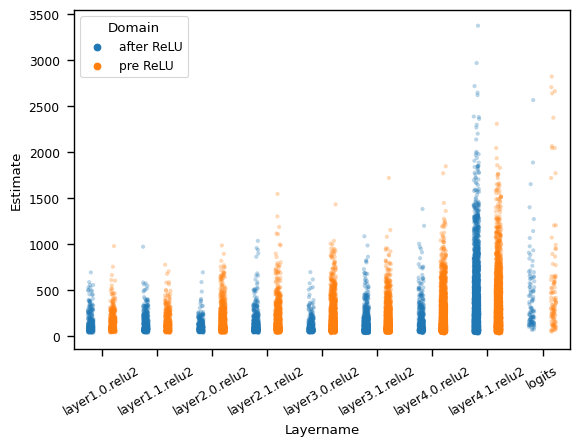

In [62]:
p = sns.stripplot(data=significant_est_fr_both, x="Layername", y="Estimate", hue="Domain", dodge=True, jitter=True, alpha=0.3, size=3)
p.set_xticklabels(p.get_xticklabels(), rotation=30)
p

/tmp/ipykernel_21683/3301451731.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator


<Axes: xlabel='Layername', ylabel='Estimate (abs.)'>

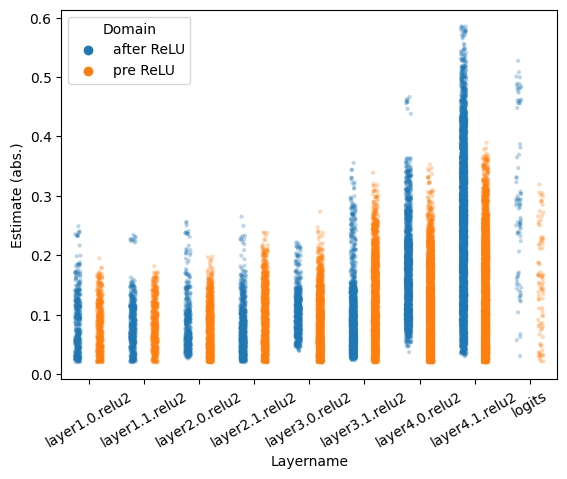

In [164]:
significant_est_fr_both["Estimate (abs.)"] = significant_est_fr_both["Estimate"].abs()
p = sns.stripplot(data=significant_est_fr_both, x="Layername", y="Estimate (abs.)", hue="Domain", dodge=True, jitter=True, alpha=0.3, size=3)
p.set_xticklabels(p.get_xticklabels(), rotation=30)
p

## Inspect a single neuron-class combination

In [79]:
df_class_fr = produce_df_class_feature_relevance(activations_dict, layers, labels, logits, binary_log_probs, 7, 464, 2, softmax_temperature=0.1)
df_class_fr
est_pcorr(df_class_fr)

{'Estimate': 0.105754236901567,
 'Estimate pvalue': 2.892308167869937e-26,
 'Estimate significant (alpha=0.05)': True}

In [80]:
df_class_fr["Class Int"] = df_class_fr["Classes"].apply(np.argmax)

In [81]:
df_class_fr

Probs.     Logits  Logits max.  Activations     Classes   
0     0.436204  19.565910    19.565910     0.049042  [1.0, 0.0]  \
1     0.366665  23.999838    23.999838    -0.345407  [1.0, 0.0]   
2     0.590924  28.622532    28.622532    -0.694339  [1.0, 0.0]   
3     0.976641  54.541245    54.541245    -0.711505  [1.0, 0.0]   
4     0.366799  19.526831    19.526831    -0.169057  [1.0, 0.0]   
...        ...        ...          ...          ...         ...   
9995  0.835544  13.112501    13.112501     0.091364  [0.0, 1.0]   
9996  0.931800  24.931564    24.931564     0.008196  [0.0, 1.0]   
9997  0.957247  14.933183    19.621107    -0.154476  [0.0, 1.0]   
9998  0.999951  67.794579    67.794579     2.426380  [0.0, 1.0]   
9999  0.978060  25.623310    25.623310     0.843837  [0.0, 1.0]   

               Domain  Class Int  
0     Above threshold          0  
1     Below threshold          0  
2     Below threshold          0  
3     Below threshold          0  
4     Below threshold          0  
...               ...        ...  
9995  Above threshold          1  
9996  Above threshold          1  
9997  Below threshold          1  
9998  Above threshold          1  
9999  Above threshold          1  

[10000 rows x 7 columns]

<Axes: xlabel='Activations', ylabel='Logits'>

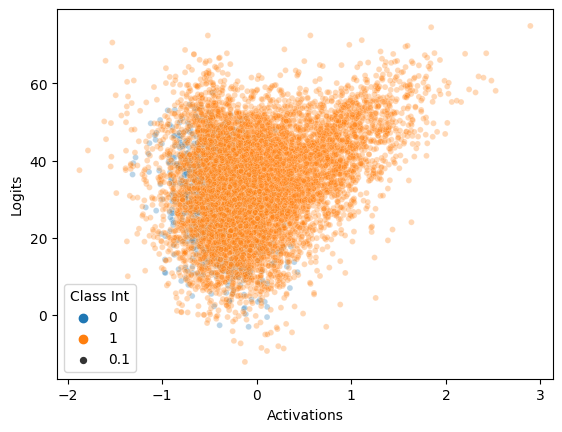

In [82]:
# sns.scatterplot(data=df_class_fr, x="Activations", y="Probs.", hue="Class Int")
sns.scatterplot(data=df_class_fr, x="Activations", y="Logits", hue="Class Int", alpha=0.3, size=0.1)

## Double check pcorr

In [117]:
# standardize
from scipy import stats
df_class_fr["Activations (standardized)"] = stats.zscore(df_class_fr["Activations"])
df_class_fr["Logits (standardized)"] = stats.zscore(df_class_fr["Logits"])
df_class_fr["Probs. (standardized)"] = stats.zscore(df_class_fr["Probs."])

In [148]:
from sklearn.linear_model import LinearRegression

df_in_class = df_class_fr.loc[df_class_fr["Class Int"] == 0]
df_out_class = df_class_fr.loc[df_class_fr["Class Int"] == 1]

X_name = "Activations"
Y_name = "Logits"
# Y_name = "Probs. (standardized)"
Z_name = "Class Int"

# This is the same as pcorr from tigramite

res_x_in = df_in_class[X_name] - df_in_class[X_name].mean()
res_x_out = df_out_class[X_name] - df_out_class[X_name].mean()
res_x = pd.concat([res_x_in, res_x_out])
res_y_in = df_in_class[Y_name] - df_in_class[Y_name].mean()
res_y_out = df_out_class[Y_name] - df_out_class[Y_name].mean()
res_y = pd.concat([res_y_in, res_y_out])

np.corrcoef(res_x, res_y)

In [ ]:
ds =  []
for _ in range(30):
    X = np.random.randn(1000)
    ds.append(rcot(X, 10*X, np.random.randn(1000), approx="hbe")[-1])
(np.array(ds) > 0).sum()/len(ds)

# Computing feature relevance...

In [18]:
softmax_temperature = 1.0
on = "Logits Difference"

fast_test_run = False

for network in ["", "2", "3", "4", "5"]:
    activations_dict_after, activations_dict_pre, logits, layers_after, layers_pre, labels, predicted_labels = load_activations_labels(network)

    est_pcorr_pos = []
    est_pcorr_full = []

    for layeri, layername in tqdm(enumerate(layers_pre)):
        for neuroni in trange(activations_dict_pre[layername][0].shape[1]):

            if fast_test_run and np.random.binomial(1, 0.99) == 1:
                continue

            for classi in range(logits.shape[1]):
                # print(layeri, neuroni, classi)
                df_class_fr = produce_df_class_feature_relevance(activations_dict_pre, layers_pre, predicted_labels, logits, binary_log_probs, layeri, neuroni, classi, softmax_temperature=softmax_temperature)

                df_class_fr_pos = df_class_fr[df_class_fr["Activations"] >= 0]

                d_pos = {"Layer": layeri, "Layername": layername, "Neuron": neuroni, "Class": classi}
                d_pos.update(est_pcorr(df_class_fr_pos, on = on))

                d_full = {"Layer": layeri, "Layername": layername, "Neuron": neuroni, "Class": classi}
                d_full.update(est_pcorr(df_class_fr, on = on))

                est_pcorr_pos.append(d_pos)
                est_pcorr_full.append(d_full)

    on_name = on.replace(".", "")
    on_name = on_name.replace(" ", "_")

    est_pcorr_pos = pd.DataFrame(est_pcorr_pos)
    est_pcorr_pos.to_csv(f"local_storage/cifar10_network_{network}_pcorr_{on_name}_estimates_pos_afterrelu.csv")

    est_pcorr_full = pd.DataFrame(est_pcorr_full)
    est_pcorr_full.to_csv(f"local_storage/cifar10_network_{network}_pcorr_{on_name}_estimates_full_afterrelu.csv")

Loading network with suffix: 
Achieved accuracy of 0.9252


0it [00:00, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

In [112]:
est_pcorr_full

Layer       Layername  Neuron  Class  Estimate  Estimate pvalue   
0          0  layer1.0.relu2       0      0  0.042615     2.022133e-05  \
1          0  layer1.0.relu2       0      1  0.036524     2.593641e-04   
2          0  layer1.0.relu2       0      2  0.017204     8.541097e-02   
3          0  layer1.0.relu2       0      3  0.025279     1.147955e-02   
4          0  layer1.0.relu2       0      4  0.018212     6.862085e-02   
...      ...             ...     ...    ...       ...              ...   
37855     15          logits       9      5  0.151492     2.109851e-52   
37856     15          logits       9      6  0.168113     2.789140e-64   
37857     15          logits       9      7  0.184425     3.331632e-77   
37858     15          logits       9      8  0.164039     3.000273e-61   
37859     15          logits       9      9  0.165597     2.123461e-62   

       Estimate significant (alpha=0.05)  
0                                   True  
1                                   True  
2                                  False  
3                                   True  
4                                  False  
...                                  ...  
37855                               True  
37856                               True  
37857                               True  
37858                               True  
37859                               True  

[37860 rows x 7 columns]

In [15]:
softmax_temperature = 1.0
on = "Logits Difference"

fast_test_run = False

for network in ["2", "3", "4", "5"]: #["", "2", "3", "4", "5"]
    activations_dict_after, activations_dict_pre, logits, layers_after, layers_pre, labels, predicted_labels = load_activations_labels(network)

    est_rcot_pos = []
    est_rcot_full = []

    for layeri, layername in tqdm(enumerate(layers_pre)):
        for neuroni in trange(activations_dict_pre[layername][0].shape[1]):

            if fast_test_run and np.random.binomial(1, 0.9) == 1:
                continue

            def compute_for_class(classi):
                df_class_fr = produce_df_class_feature_relevance(activations_dict_pre, layers_pre, predicted_labels, logits, binary_log_probs, layeri, neuroni, classi, softmax_temperature=softmax_temperature)

                df_class_fr_pos = df_class_fr[df_class_fr["Activations"] >= 0]

                d_pos = {"Layer": layeri, "Layername": layername, "Neuron": neuroni, "Class": classi}
                d_pos.update(est_rcot(df_class_fr_pos, on = on))

                return d_pos

                # d_full = {"Layer": layeri, "Layername": layername, "Neuron": neuroni, "Class": classi}
                # d_full.update(est_rcot(df_class_fr, on = on))

            classid_array = [*range(logits.shape[1])]

            with ProcessPoolExecutor(max_workers=6) as executor:
                for d_pos in executor.map(compute_for_class, classid_array):
                    est_rcot_pos.append(d_pos)

            # for classi in range(logits.shape[1]):
            #     # print(layeri, neuroni, classi)
                

            #     est_rcot_pos.append(d_pos)
            #     # est_rcot_full.append(d_full)

    on_name = on.replace(".", "")
    on_name = on_name.replace(" ", "_")

    est_rcot_pos = pd.DataFrame(est_rcot_pos)
    est_rcot_pos.to_csv(f"local_storage/cifar10_network_{network}_rcot_{on_name}_estimates_pos_afterrelu.csv")

    # est_rcot_full = pd.DataFrame(est_rcot_full)
    # est_rcot_full.to_csv(f"local_storage/cifar10_network_{network}_rcot_{on_name}_estimates_full_afterrelu.csv")

Loading network with suffix: 2
Achieved accuracy of 0.9195


0it [00:00, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!



  0%|          | 0/64 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing R

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCO

  0%|          | 0/128 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing R

  0%|          | 0/128 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing R

  0%|          | 0/128 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCO

  0%|          | 0/256 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing R

  0%|          | 0/256 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!


  0%|          | 0/256 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!



Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing R

  0%|          | 0/256 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing R

  0%|          | 0/512 [00:00<?, ?it/s]

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RC

  0%|          | 0/512 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCO

  0%|          | 0/512 [00:00<?, ?it/s]

Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is need

  0%|          | 0/512 [00:00<?, ?it/s]

Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Comput

  0%|          | 0/10 [00:00<?, ?it/s]

Loading network with suffix: 3
Achieved accuracy of 0.9261


0it [00:00, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!



Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing R

  0%|          | 0/64 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing R

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing R

  0%|          | 0/128 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing R

  0%|          | 0/128 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing R

  0%|          | 0/128 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!


  0%|          | 0/256 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing R

  0%|          | 0/256 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing R

  0%|          | 0/256 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCO

  0%|          | 0/256 [00:00<?, ?it/s]

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!



Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RC

  0%|          | 0/512 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RC

  0%|          | 0/512 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCO

  0%|          | 0/512 [00:00<?, ?it/s]

Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is need

  0%|          | 0/512 [00:00<?, ?it/s]

Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!


  0%|          | 0/10 [00:00<?, ?it/s]

Loading network with suffix: 4
Achieved accuracy of 0.9033


0it [00:00, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!


Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!


Computing RCOT failed!Computing RCOT failed!



  0%|          | 0/64 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing R

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RC

  0%|          | 0/128 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing R

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing R

  0%|          | 0/256 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing R

  0%|          | 0/256 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing R

  0%|          | 0/256 [00:00<?, ?it/s]

Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!



  0%|          | 0/512 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RC

  0%|          | 0/512 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RC

  0%|          | 0/512 [00:00<?, ?it/s]

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RC

  0%|          | 0/512 [00:00<?, ?it/s]

Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!

Computing RCOT failed!Computing RCOT failed!
Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!Computing RCOT failed!


Computing RCOT failed!

Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is needed!
Computing RCOT failed!
Z is constant! Unconditional independence test is need

  0%|          | 0/10 [00:00<?, ?it/s]

Loading network with suffix: 5
Achieved accuracy of 0.9261


0it [00:00, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [86]:
df_class_fr = produce_df_class_feature_relevance(activations_dict, layers, logits, binary_log_probs, layeri, neuroni, classi, softmax_temperature=0.1)

df_class_fr = df_class_fr[df_class_fr["Activations"] >= 0]

est_pcorr(df_class_fr)

{'Estimate': -0.3521224755171544,
 'Estimate pvalue': 0.18104152771678478,
 'Estimate significant (alpha=0.05)': False}

### TODO: there is still something wrong... i can't just copy the activations.. they belong to samples of specific classes.. i should have only 10000 samples at the end

it should have: activation which belongs to a sample of a specific class. the targets are then the probabilities for the different classes. this would give relevances for the different classes..

Q: am i missing something???

In [63]:
logits.shape

(10000, 10)

In [68]:
df_all_classes["Classes"]

df_all_classes.loc[1]["Classes"] = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
df_all_classes.loc[1]["Classes"]

/tmp/ipykernel_22116/525515705.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1

# RDD experiments... I don't feel that this is sound

Most activations above 0 could be explained by extrapolating. Probably, the distribution left and right is not even enough.

Look at RDD again. Plot the logs of class probs over the activations of a neuron. Start with high layers.

Set some threshold as some samples will have very low log probs.

Compute 'gradient' as well (diff logs / diff activations)

Check: https://causalpy.readthedocs.io/en/latest/notebooks/rd_pymc_drinking.html

! NOPE, NOT WORKING. BUT THIS IS STILL SOMEHOW INTERESTING I GUESS

## Inspect a lot of neurons

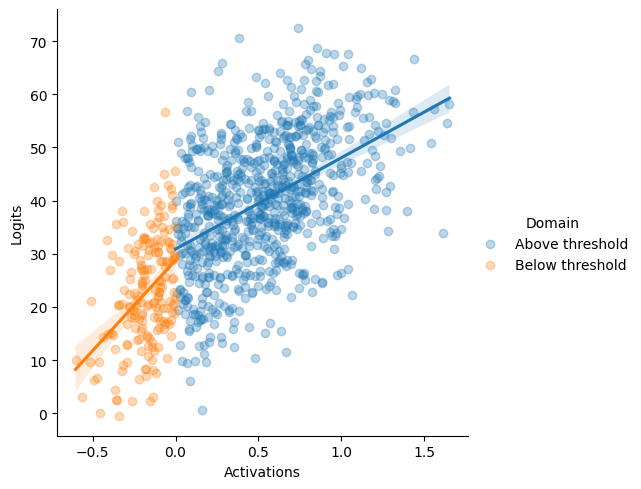

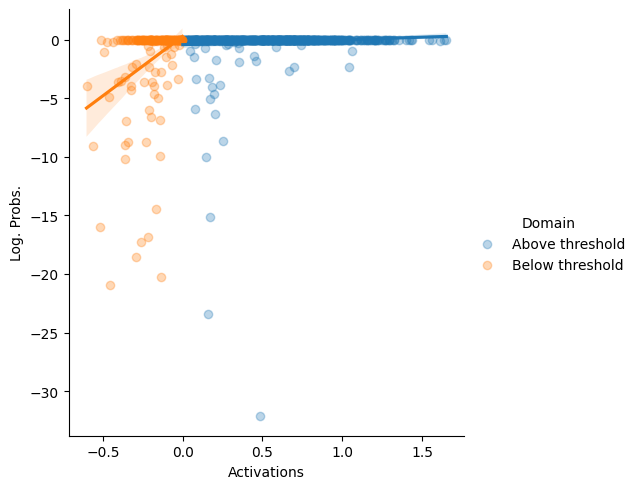

In [73]:
# for _ in range(10):
layeri, neuroni = 7, np.random.randint(512)
classi = np.random.randint(10)

df_class = produce_df_in_class(activations_dict_pre, layers_pre, labels, logits_pre, layeri, neuroni, classi)
sns.lmplot(x = "Activations", y = "Logits", data=df_class, hue="Domain", scatter_kws={'alpha':0.3})
sns.lmplot(x = "Activations", y = "Log. Probs.", data=df_class, hue="Domain", scatter_kws={'alpha':0.3})

In [74]:
df_class_sorted = df_class.sort_values(by="Activations")
df_class_sorted['Abs. Diff. Activations'] = df_class_sorted["Activations"].diff().abs()
df_class_sorted['Diff. Logits'] = df_class_sorted["Logits"].diff()
df_class_sorted['Diff. Log. Probs.'] = df_class_sorted["Log. Probs."].diff()

df_class_sorted['Logits (Finite differences)'] = df_class_sorted['Diff. Logits'] / df_class_sorted['Abs. Diff. Activations']
df_class_sorted['Log. Probs. (Finite differences)'] = df_class_sorted['Diff. Log. Probs.'] / df_class_sorted['Abs. Diff. Activations']

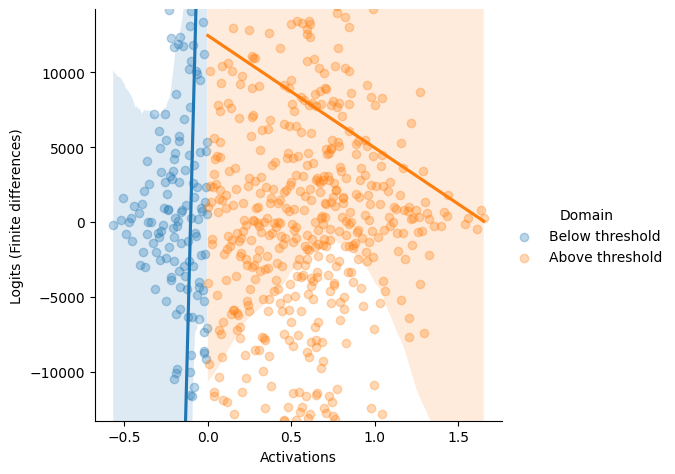

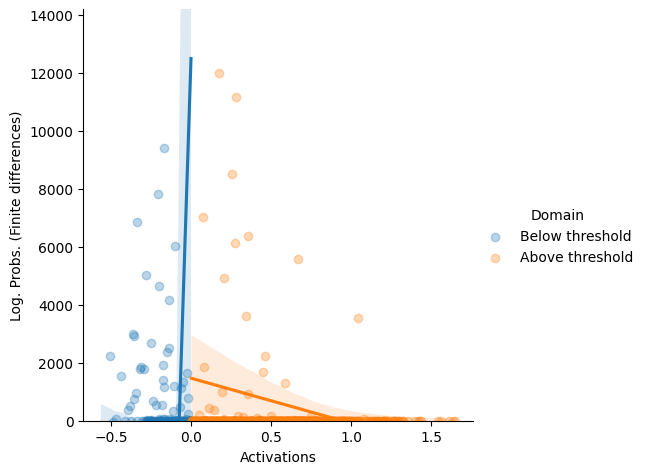

In [75]:
show_quantile = 0.8

g = sns.lmplot(x = "Activations", y = "Logits (Finite differences)", data=df_class_sorted, hue="Domain", scatter_kws={'alpha':0.3})
ylims = (df_class_sorted['Logits (Finite differences)'].quantile(1-show_quantile), df_class_sorted['Logits (Finite differences)'].quantile(show_quantile))
g.set(ylim=ylims)

g = sns.lmplot(x = "Activations", y = "Log. Probs. (Finite differences)", data=df_class_sorted, hue="Domain", scatter_kws={'alpha':0.3})
ylims = (df_class_sorted['Log. Probs. (Finite differences)'].quantile(1-show_quantile), df_class_sorted['Logits (Finite differences)'].quantile(show_quantile))
g.set(ylim=ylims)

## Try partial correlation of neurons given all samples, their classes and logits.

## Load dataframes, those which have the least invalid RDD estimates

In [20]:
bwselect= "msetwo"
robust_rdd_logits_df = pd.read_csv(f"local_storage/cifar10_rdd_estimates_{bwselect}_afterrelu.csv")

perc = robust_rdd_logits_df["Estimate"].notna().sum()/len(robust_rdd_logits_df["Estimate"])
print(f"Valid neuron-class combinations for {bwselect}: {perc * 100}%")

Valid neuron-class combinations for msetwo: 6.818652849740933%


/tmp/ipykernel_21242/360877066.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator


<Axes: xlabel='Layername', ylabel='Estimate'>

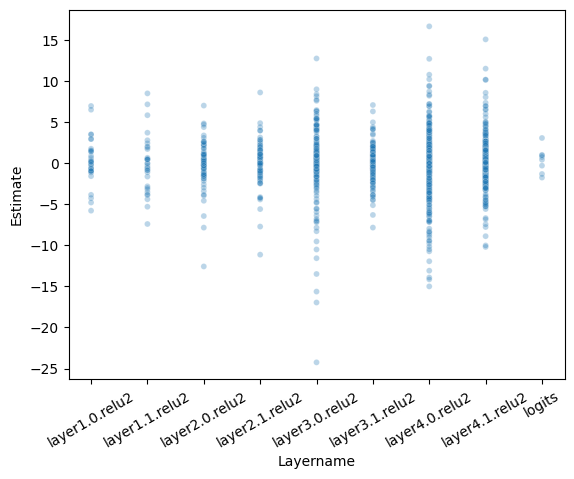

In [21]:
p = sns.scatterplot(data=robust_rdd_logits_df, x="Layername", y="Estimate", alpha=0.3, size=0.1)
p.set_xticklabels(p.get_xticklabels(), rotation=30)
p.legend_.remove()
p

## Inspect these neurons

In [27]:
robust_rdd_logits_df.loc[robust_rdd_logits_df["Estimate"] > 10]

Unnamed: 0  Layer       Layername  Neuron  Class   Estimate
4440         4440      4  layer3.0.relu2      60      0  12.722591
10015       10015      6  layer4.0.relu2     105      5  10.197374
10224       10224      6  layer4.0.relu2     126      4  12.681694
11076       11076      6  layer4.0.relu2     211      6  16.629756
11493       11493      6  layer4.0.relu2     253      3  10.747306
14647       14647      7  layer4.1.relu2      56      7  11.485663
14751       14751      7  layer4.1.relu2      67      1  10.144484
15828       15828      7  layer4.1.relu2     174      8  15.044733
18051       18051      7  layer4.1.relu2     397      1  10.125832

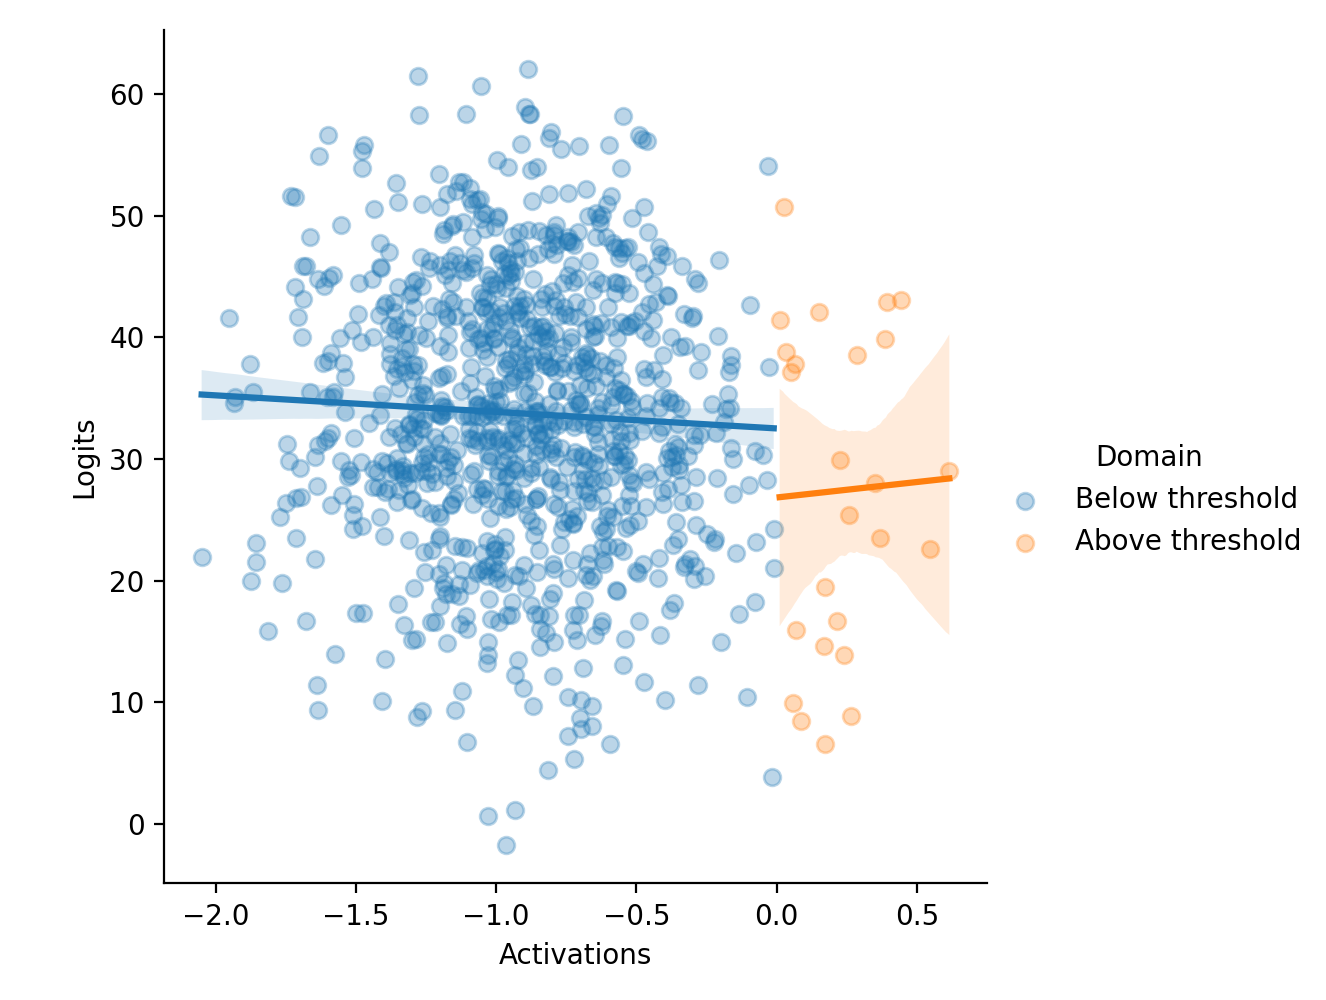

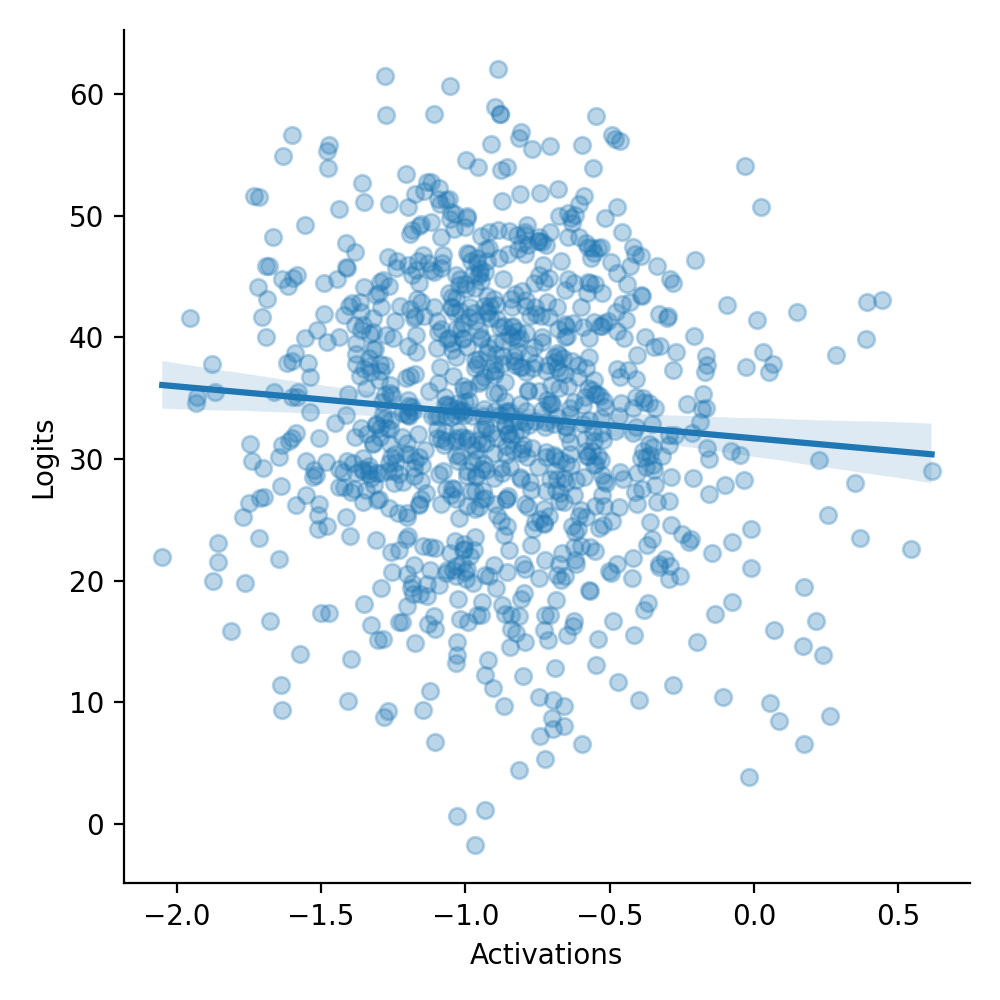

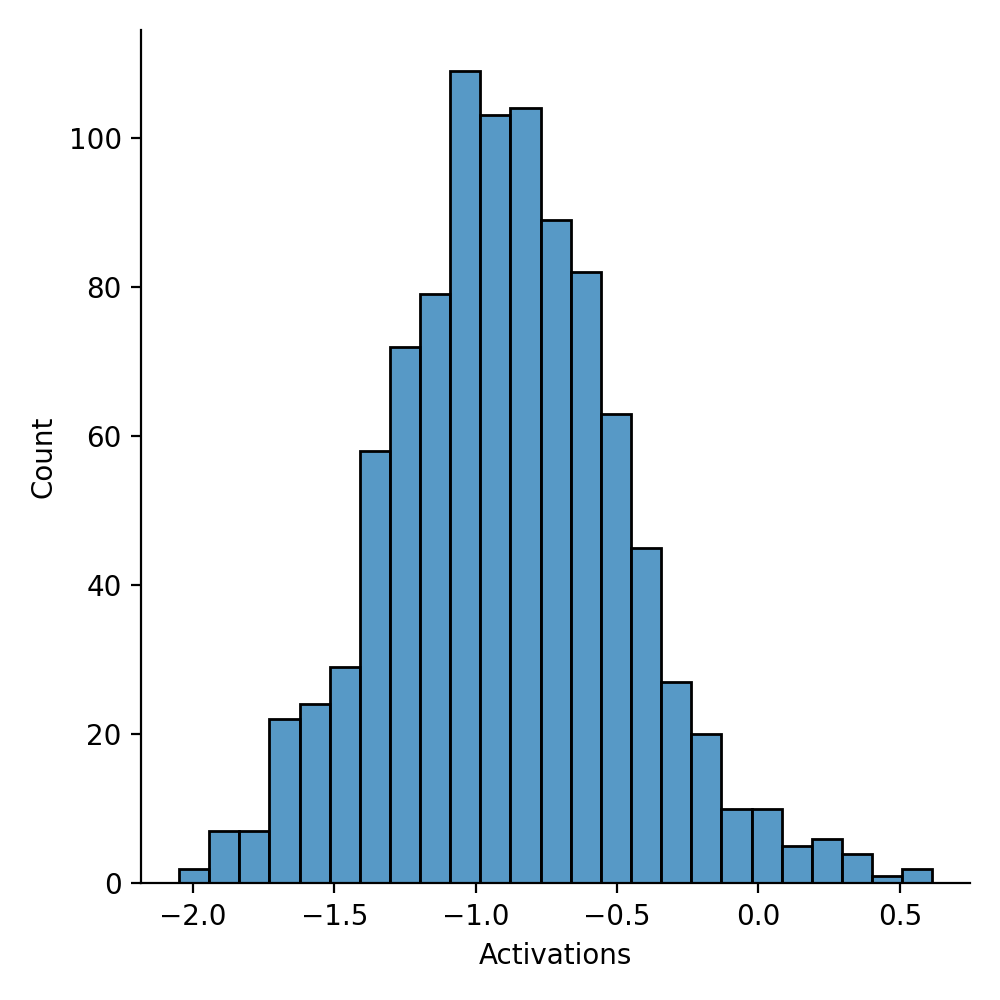

In [31]:
layeri, neuroni = 6, 211
classi = 6

df_class = produce_df_in_class(activations_dict, layers, labels, logits, layeri, neuroni, classi)
sns.lmplot(x = "Activations", y = "Logits", data=df_class, hue="Domain", scatter_kws={'alpha':0.3})
sns.lmplot(x = "Activations", y = "Logits", data=df_class, scatter_kws={'alpha':0.3})
sns.displot(df_class, x="Activations")

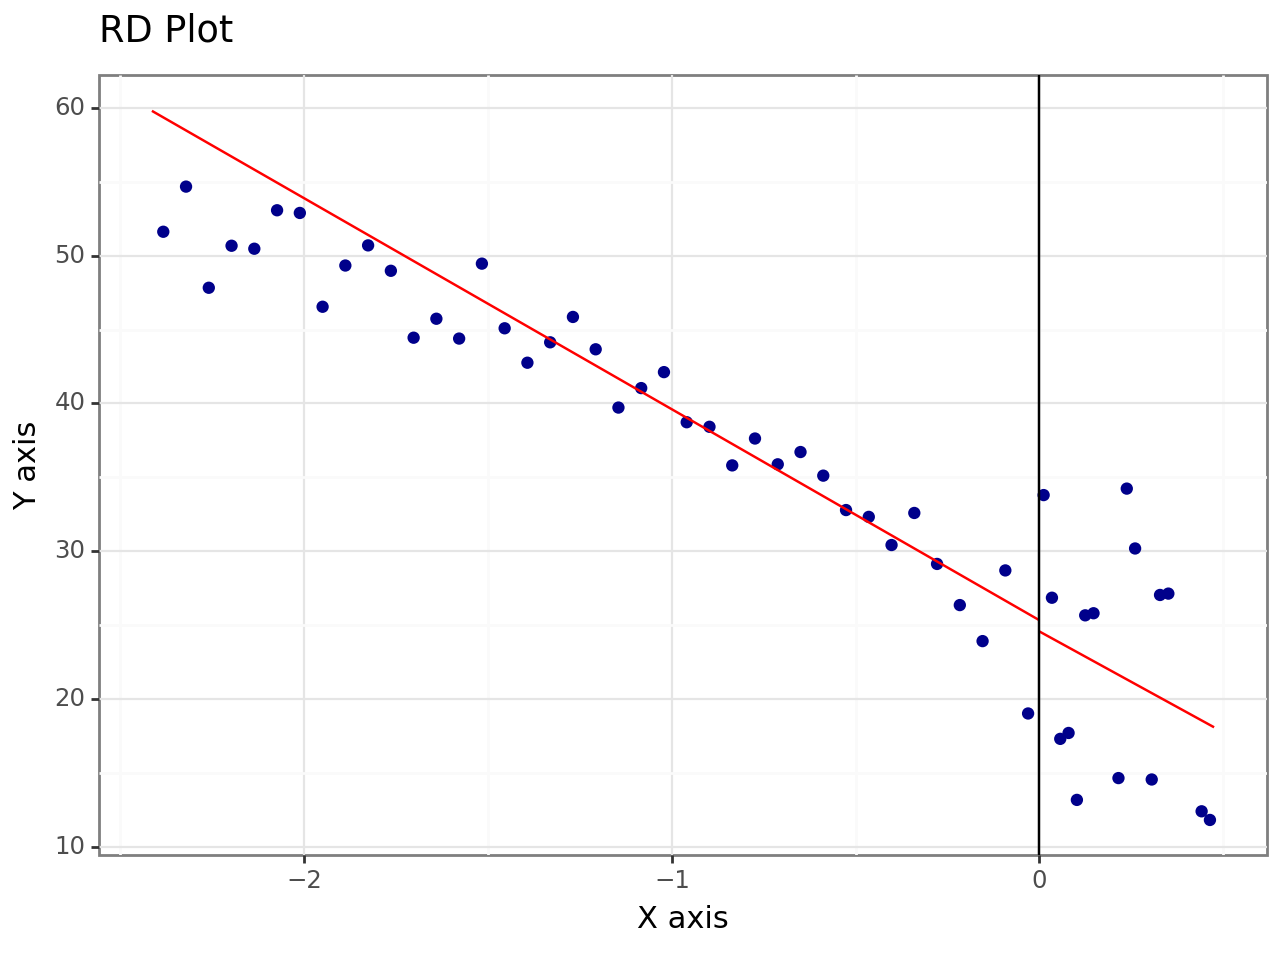


Call: rdplot
Number of Observations:                  1003
Kernel:                            Triangular
Polynomial Order Est. (p):                  1

                                Left      Right
------------------------------------------------
Number of Observations           970         33
Number of Effective Obs          969         32
Bandwith poly. fit (h)         2.414      0.475
Number of bins scale               1          1
Bins Selected                     39         21
Average Bin Length             0.062      0.023
Median Bin Length              0.062      0.023
IMSE-optimal bins               15.0        7.0
Mimicking Variance bins         39.0       21.0

Relative to IMSE-optimal:
Implied scale                    2.6        3.0
WIMSE variance weight          0.054      0.036
WIMSE bias weight              0.946      0.964


In [29]:
rdplot(df_class["Logits"], df_class["Activations"], p=1, kernel="triangular")

## Bootstrapping is too unstable

In [ ]:
est_df = pd.read_csv("local_storage/cifar10_rdd_estimates_afterrelu.csv")

In [ ]:
print(f"Valid neuron-class combinations: {est_df['Estimate'].notna().sum()/len(est_df) * 100}%")

In [ ]:
est_df.loc[est_df['Estimate'].abs().idxmax()]

In [ ]:
est_df.sort_values(by='Estimate', key=lambda est: est.abs(), ascending=False)

### The maximum RDD neuron is a bad example. Too few neurons on one side of the threshold.
### Second one, also not good.
### 3, 4,  bad.

# Inspect single neuron

In [28]:
layeri, neuroni = 6, 196
classi = 1
classname = util.cifar10_names[classi]

In [29]:
acts = np.vstack(activations_dict[layers[layeri]])[:, neuroni]

In [30]:
selected_quantile = None

In [31]:
df_class, xlims_class = produce_df_in_class(activations_dict, layers, labels, logits, layeri, neuroni, classi, quantile=0.25)

Should not use quantile=True` for passing it to `rdrobust`!


In [16]:
linr = sm.OLS(df_class['Logits'], sm.add_constant(df_class['Activations']))
res = linr.fit()
print(res.summary())
res.pvalues['Activations'], res.params['Activations'], res.bse['Activations']
res.pvalues['const'], res.params['const'], res.bse['const']

                            OLS Regression Results                            
Dep. Variable:                 Logits   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     74.46
Date:                Tue, 23 May 2023   Prob (F-statistic):           7.07e-16
Time:                        17:20:31   Log-Likelihood:                -916.99
No. Observations:                 254   AIC:                             1838.
Df Residuals:                     252   BIC:                             1845.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          21.5257      1.246     17.279      

(1.1657542131243247e-44, 21.525717884514933, 1.245765921614408)

# Compute regressions

In [105]:
# OLD, and unnecessary to compute, see comment in the corresponding section
# est_regression_df_pos_acts_class_true = []
# est_regression_df_full_acts_class_true = []
# est_regression_df_pos_acts_class_predicted = []
# est_regression_df_full_acts_class_predicted = []

est_regression_df_pos_acts_class_logits = []
est_regression_df_full_acts_class_logits = []

# DON'T RECOMPUTE AGAIN
est_regression_df_pos_acts_max_class = []
est_regression_df_full_acts_max_class = []

for layeri, layername in enumerate(layers):
    for neuroni in range(activations_dict[layername][0].shape[1]):
        for classi in range(logits.shape[1]):
            # OLD, and unnecessary to compute, see comment in the corresponding section
            # for labels_, est_df_list_pos, est_df_list_full in [(labels, est_regression_df_pos_acts_class_true, est_regression_df_full_acts_class_true), (predicted_labels, est_regression_df_pos_acts_class_predicted, est_regression_df_full_acts_class_predicted)]:
            for est_df_list_pos, est_df_list_full in [(est_regression_df_pos_acts_class_logits, est_regression_df_full_acts_class_logits)]:
                
                print(layeri, neuroni, classi)
                # df_class = produce_df_class(activations_dict, layers, labels_, logits, layeri, neuroni, classi)
                df_class_logits = produce_df_class_logits(activations_dict, layers, logits, layeri, neuroni, classi)
                
                pos_res, full_res = pos_full_activations_regression(df_class_logits)
                
                d_pos = {"Layer": layeri, "Layername": layername, "Neuron": neuroni, "Class": classi}
                d_pos.update(pos_res)

                d_full = {"Layer": layeri, "Layername": layername, "Neuron": neuroni, "Class": classi}
                d_full.update(full_res)
                
                est_df_list_pos.append(d_pos)
                est_df_list_full.append(d_full)
        
        # DON'T RECOMPUTE AGAIN
        # max class
        df = produce_df_max_class(activations_dict, layers, logits, layeri, neuroni)
        pos_res, full_res = pos_full_activations_regression(df)
                
        d_pos = {"Layer": layeri, "Layername": layername, "Neuron": neuroni}
        d_pos.update(pos_res)

        d_full = {"Layer": layeri, "Layername": layername, "Neuron": neuroni}
        d_full.update(full_res)
        
        est_regression_df_pos_acts_max_class.append(d_pos)
        est_regression_df_full_acts_max_class.append(d_full)

# OLD, and unnecessary to compute, see comment in the corresponding section
# est_regression_df_pos_acts_class_true = pd.DataFrame(est_regression_df_pos_acts_class_true)
# est_regression_df_pos_acts_class_true.to_csv("local_storage/cifar10_est_regression_df_pos_acts_class_true_afterrelu.csv")
# est_regression_df_full_acts_class_true = pd.DataFrame(est_regression_df_full_acts_class_true)
# est_regression_df_full_acts_class_true.to_csv("local_storage/cifar10_est_regression_df_full_acts_class_true_afterrelu.csv")
# est_regression_df_pos_acts_class_predicted = pd.DataFrame(est_regression_df_pos_acts_class_predicted)
# est_regression_df_pos_acts_class_predicted.to_csv("local_storage/cifar10_est_regression_df_pos_acts_class_predicted_afterrelu.csv")
# est_regression_df_full_acts_class_predicted = pd.DataFrame(est_regression_df_full_acts_class_predicted)
# est_regression_df_full_acts_class_predicted.to_csv("local_storage/cifar10_est_regression_df_full_acts_class_predicted_afterrelu.csv")

est_regression_df_pos_acts_class_logits = pd.DataFrame(est_regression_df_pos_acts_class_logits)
est_regression_df_pos_acts_class_logits.to_csv("local_storage/cifar10_est_regression_df_pos_acts_class_logits_afterrelu.csv")
est_regression_df_full_acts_class_logits = pd.DataFrame(est_regression_df_full_acts_class_logits)
est_regression_df_full_acts_class_logits.to_csv("local_storage/cifar10_est_regression_df_full_acts_class_logits_afterrelu.csv")

# DON'T RECOMPUTE AGAIN
est_regression_df_pos_acts_max_class = pd.DataFrame(est_regression_df_pos_acts_max_class)
est_regression_df_pos_acts_max_class.to_csv("local_storage/cifar10_est_regression_df_pos_acts_max_class_afterrelu.csv")
est_regression_df_full_acts_max_class = pd.DataFrame(est_regression_df_full_acts_max_class)
est_regression_df_full_acts_max_class.to_csv("local_storage/cifar10_est_regression_df_full_acts_max_class_afterrelu.csv")

0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 0 5
0 0 6
0 0 7
0 0 8
0 0 9
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 1 5
0 1 6
0 1 7
0 1 8
0 1 9
0 2 0
0 2 1
0 2 2
0 2 3
0 2 4
0 2 5
0 2 6
0 2 7
0 2 8
0 2 9
0 3 0
0 3 1
0 3 2
0 3 3
0 3 4
0 3 5
0 3 6
0 3 7
0 3 8
0 3 9
0 4 0
0 4 1
0 4 2
0 4 3
0 4 4
0 4 5
0 4 6
0 4 7
0 4 8
0 4 9
0 5 0
0 5 1
0 5 2
0 5 3
0 5 4
0 5 5
0 5 6
0 5 7
0 5 8
0 5 9
0 6 0
0 6 1
0 6 2
0 6 3
0 6 4
0 6 5
0 6 6
0 6 7
0 6 8
0 6 9
0 7 0
0 7 1
0 7 2
0 7 3
0 7 4
0 7 5
0 7 6
0 7 7
0 7 8
0 7 9
0 8 0
0 8 1
0 8 2
0 8 3
0 8 4
0 8 5
0 8 6
0 8 7
0 8 8
0 8 9
0 9 0
0 9 1
0 9 2
0 9 3
0 9 4
0 9 5
0 9 6
0 9 7
0 9 8
0 9 9
0 10 0
0 10 1
0 10 2
0 10 3
0 10 4
0 10 5
0 10 6
0 10 7
0 10 8
0 10 9
0 11 0
0 11 1
0 11 2
0 11 3
0 11 4
0 11 5
0 11 6
0 11 7
0 11 8
0 11 9
0 12 0
0 12 1
0 12 2
0 12 3
0 12 4
0 12 5
0 12 6
0 12 7
0 12 8
0 12 9
0 13 0
0 13 1
0 13 2
0 13 3
0 13 4
0 13 5
0 13 6
0 13 7
0 13 8
0 13 9
0 14 0
0 14 1
0 14 2
0 14 3
0 14 4
0 14 5
0 14 6
0 14 7
0 14 8
0 14 9
0 15 0
0 15 1
0 15 2
0 15 3
0 15 4
0 15 5
0 15 6
0

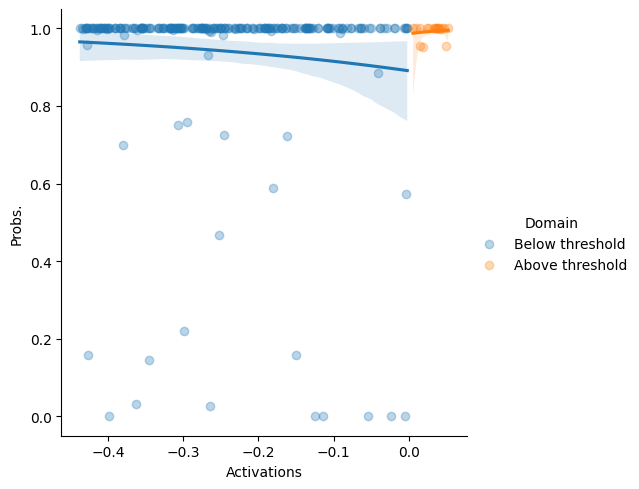

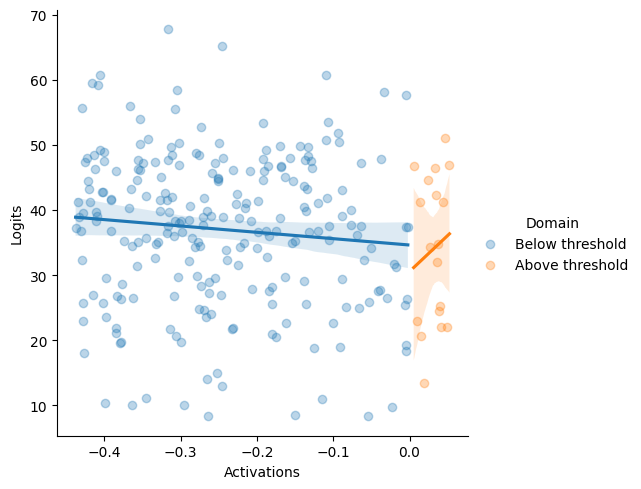

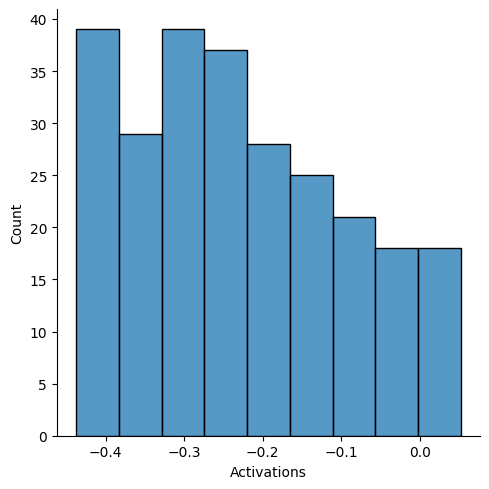

In [33]:
sns.lmplot(x = "Activations", y = "Probs.", data=df_class, hue="Domain", logistic=True, scatter_kws={'alpha':0.3})
sns.lmplot(x = "Activations", y = "Logits", data=df_class, hue="Domain", scatter_kws={'alpha':0.3})
sns.displot(df_class, x="Activations")

In [35]:
# bootn = 1000
# bootinds = np.random.randint(0, len(df_class)-1, size=(bootn, len(df_class)))

# estimates_left = []
# estimates_right = []
# for boot in bootinds:
#     df_class_boot = df_class.loc[boot]
#     l, r = est_left_right(df_class_boot, xlims_class) # the xlims are not exactly correct now.. but i think this is like a hparam
#     estimates_left.append(l), estimates_right.append(r)

# diffs = np.array(estimates_right)[:, np.newaxis] - np.array(estimates_left)[np.newaxis, :]
# np.nanmean(diffs)

In [36]:
# bootn = 1000
# results = Parallel(n_jobs=4)(delayed(est_left_right)(df_class.sample(frac=1, replace=True), xlims_class)
#                           for _ in range(bootn))
# results = np.array(results)
# diffs = results[:, 1, np.newaxis] - results[np.newaxis, :, 0]
# np.nanmean(diffs), np.nanstd(diffs)

In [39]:
quantile = 0.25
est_df_boot = []
for layeri, layername in enumerate(layers):
    for neuroni in range(activations_dict[layername][0].shape[1]):
        for classi in range(logits.shape[1]):
            print(layeri, neuroni, classi)
            df_class, xlims_class = produce_df_in_class(activations_dict, layers, labels, logits, layeri, neuroni, classi, quantile=quantile)
            est, est_std = bootstrapped_rdd(df_class, xlims_class)
            d = {"Layer": layeri, "Layername": layername, "Neuron": neuroni, "Class": classi, "Estimate": est, "Estimate Std.": est_std}
            est_df_boot.append(d)
est_df_boot = pd.DataFrame(est_df_boot)

est_df_boot.to_csv("local_storage/cifar10_rdd_estimates_boot_afterrelu.csv")

0 0 0
Should not use quantile=True` for passing it to `rdrobust`!
0 0 1
Should not use quantile=True` for passing it to `rdrobust`!
0 0 2
Should not use quantile=True` for passing it to `rdrobust`!
0 0 3
Should not use quantile=True` for passing it to `rdrobust`!
0 0 4
Should not use quantile=True` for passing it to `rdrobust`!
0 0 5
Should not use quantile=True` for passing it to `rdrobust`!
0 0 6
Should not use quantile=True` for passing it to `rdrobust`!
0 0 7
Should not use quantile=True` for passing it to `rdrobust`!
0 0 8
Should not use quantile=True` for passing it to `rdrobust`!
0 0 9
Should not use quantile=True` for passing it to `rdrobust`!
0 1 0
Should not use quantile=True` for passing it to `rdrobust`!
0 1 1
Should not use quantile=True` for passing it to `rdrobust`!
0 1 2
Should not use quantile=True` for passing it to `rdrobust`!
0 1 3
Should not use quantile=True` for passing it to `rdrobust`!
0 1 4
Should not use quantile=True` for passing it to `rdrobust`!
0 1 5
Shou

In [ ]:
df_class, xlims_class = produce_df_in_class(activations_dict, layers, labels, logits, 0, 0, 0, quantile=quantile)
# est, est_std = 
bootstrapped_rdd(df_class, xlims_class)

In [ ]:
df_class, xlims_class = produce_df_in_class(activations_dict, layers, labels, logits, 0, 0, 0, quantile=quantile)
# est, est_std = 
est_left_right(df_class.sample(frac=1, replace=True), xlims_class)

In [38]:
estimate_rdd_effect(df_class['Logits'], df_class['Activations'])

nan

In [ ]:
est_df_boot

In [22]:
for bwselect in ["mserd", "msetwo", "certwo"]:
    est_df = []
    for layeri, layername in enumerate(layers):
        for neuroni in range(activations_dict[layername][0].shape[1]):
            for classi in range(logits.shape[1]):
                df_class = produce_df_in_class(activations_dict, layers, labels, logits, layeri, neuroni, classi)
                est = estimate_rdd_effect(df_class['Logits'], df_class['Activations'], bwselect=bwselect)
                # print(f"Layer: {layeri}, Neuron: {neuroni}, Class: {classi}, Estimate: {est}")
                d = {"Layer": layeri, "Layername": layername, "Neuron": neuroni, "Class": classi, "Estimate": est}
                est_df.append(d)
    est_df = pd.DataFrame(est_df)

    est_df.to_csv(f"local_storage/cifar10_rdd_estimates_{bwselect}_afterrelu.csv")

rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:512: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdrobust.py:689: RuntimeWarning: invalid value encountered in sqrt


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:502: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/funs.py:312: RuntimeWarning: invalid value encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:520: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdrobust.py:688: RuntimeWarning: invalid value encountered in sqrt


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:449: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:460: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:436: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:435: RuntimeWarning: divide by zero encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:435: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:450: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:436: RuntimeWarning: divide by zero encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:461: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

In [31]:
for bwselect in ["mserd", "msetwo", "certwo"]:
    loaded_df = pd.read_csv(f"local_storage/cifar10_rdd_estimates_{bwselect}_afterrelu.csv")
    perc = loaded_df["Estimate"].notna().sum()/len(loaded_df["Estimate"])
    print(f"Valid neuron-class combinations for {bwselect}: {perc * 100}%")

Valid neuron-class combinations for mserd: 5.518134715025907%
Valid neuron-class combinations for msetwo: 6.818652849740933%
Valid neuron-class combinations for certwo: 6.44559585492228%


In [25]:
for bwselect in ["mserd", "msetwo", "certwo"]:
    est_df = []
    for layeri, layername in enumerate(layers):
        for neuroni in range(activations_dict[layername][0].shape[1]):
            for classi in range(logits.shape[1]):
                df_class = produce_df_in_class(activations_dict, layers, labels, logits, layeri, neuroni, classi)
                est = estimate_rdd_effect(df_class['Log. Probs.'], df_class['Activations'], bwselect=bwselect)
                # print(f"Layer: {layeri}, Neuron: {neuroni}, Class: {classi}, Estimate: {est}")
                d = {"Layer": layeri, "Layername": layername, "Neuron": neuroni, "Class": classi, "Estimate": est}
                est_df.append(d)
    est_df = pd.DataFrame(est_df)

    est_df.to_csv(f"local_storage/cifar10_rdd_estimates_logprobs_{bwselect}_afterrelu.csv")

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:512: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/funs.py:312: RuntimeWarning: invalid value encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:520: RuntimeWarning: divide by zero encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:502: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdrobust.py:693: RuntimeWarning: divide by zero encountered in divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdrobust.py:693: RuntimeWarning: invalid value encountered in divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:520: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdrobust.py:688: RuntimeWarning: invalid value encountered in sqrt
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdrobust.py:689: RuntimeWarning: invalid value encountered in sqrt


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:512: RuntimeWarning: divide by zero encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:461: RuntimeWarning: divide by zero encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/funs.py:275: RuntimeWarning: divide by zero encountered in divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/funs.py:281: RuntimeWarning: invalid value encountered in multiply


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:449: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:460: RuntimeWarning: divide by zero encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:449: RuntimeWarning: divide by zero encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:435: RuntimeWarning: invalid value encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:435: RuntimeWarning: divide by zero encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:460: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:436: RuntimeWarning: invalid value encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:436: RuntimeWarning: divide by zero encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:450: RuntimeWarning: divide by zero encountered in scalar divide


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:450: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:436: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:461: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:435: RuntimeWarning: invalid value encountered in scalar power


rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust failed
rdorobust fail

In [32]:
# thats similar to before
for bwselect in ["mserd", "msetwo", "certwo"]:
    loaded_df = pd.read_csv(f"local_storage/cifar10_rdd_estimates_logprobs_{bwselect}_afterrelu.csv")
    perc = loaded_df["Estimate"].notna().sum()/len(loaded_df["Estimate"])
    print(f"Valid neuron-class combinations for {bwselect}: {perc * 100}%")

Valid neuron-class combinations for mserd: 2.8756476683937824%
Valid neuron-class combinations for msetwo: 6.865284974093264%
Valid neuron-class combinations for certwo: 6.22279792746114%


In [ ]:
# TODO: check how many failed..
# try different bandwidth selectors: certwo, msetwo
# why do so much more fail now? what happens for log of prob (like it was before...)

In [ ]:
(est_df["Estimate"] == est_df["Estimate"]).sum(), (est_df["Estimate"] == est_df["Estimate"]).sum()/(len(est_df["Estimate"]))

In [ ]:
# inlims_acts = acts[inlims]
# logits_all = np.max(logits, axis=1)[inlims]

# probs_all = np.max(probs, axis=1)[inlims]

# logprobs_all = np.log(probs_all)
# domain_all = np.array(["Above threshold" if a >= 0 else "Below threshold" for a in acts])[inlims]

# df_all = pd.DataFrame({"Log. Probs.": logprobs_all, 
#                    "Probs.": probs_all,
#                    "Logits": logits_all,
#                    "Activations": inlims_acts, "Domain": domain_all})                   

In [ ]:
#DONE: i need the log probs of the classes
# check accuracy of logprobs. this is fine :)
# (np.vstack(activations_dict[layers[-1]]).argmax(axis=1) == labels).sum()/len(labels)

In [ ]:
# sns.lmplot(x = "Activations", y = "Probs.", data=df_all, hue="Domain", logistic=True, scatter_kws={'alpha':0.3})
# sns.lmplot(x = "Activations", y = "Log. Probs.", data=df_all, hue="Domain", scatter_kws={'alpha':0.3})
# sns.lmplot(x = "Activations", y = "Logits", data=df_all, hue="Domain", scatter_kws={'alpha':0.3})
# sns.displot(df_all, x="Activations")

In [ ]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial

#TODO: what happens if adding one vector?

df_bt = df_class.loc[df_class["Domain"] == "Below threshold"]
logisitic_regression_bt = GLM(df_bt["Probs."], df_bt["Activations"], family=Binomial()).fit()

df_at = df_class.loc[df_class["Domain"] == "Above threshold"]
logisitic_regression_at = GLM(df_at["Probs."], df_at["Activations"], family=Binomial()).fit()

logisitic_regression_bt_with_intercept = GLM(df_bt["Probs."], np.c_[np.ones(len(df_bt["Activations"])), df_bt["Activations"]], family=Binomial()).fit()
logisitic_regression_at_with_intercept = GLM(df_at["Probs."], np.c_[np.ones(len(df_at["Activations"])), df_at["Activations"]], family=Binomial()).fit()

In [ ]:
logisitic_regression_bt.predict(-0.001), logisitic_regression_at.predict(0.001), logisitic_regression_bt_with_intercept.predict([1, -0.001]), logisitic_regression_at_with_intercept.predict([1, 0.001])

In [ ]:
#TODO: that it still too bad... seaborn used bootstrapping. Copy it from seaborn. Strip the plotting stuff

#TODO: implement triangular kernel weighting

#TODO: the difference between means might not be the best. but maybe one can compute the avg. of distances from the bootstrap samples
#TODO: can this be used to classify inhibitory and excitatory neurons?

#TODO: use all samples and weigh samples according to classes -> no, Wait

# What might be good RDDs?
# All samples to their max log prob (any class) -> reveals if a neuron is generally excitatory or inhibitory and how relevant it generally is
# For a class, is this neuron relevant? This should really focus on samples from that class

# regressing the logits is more close to the jacobian of the output neurons

In [ ]:
# Why does seaborn add ones to the X used in GLM? It's the intercept. like sm.add_constant

In [ ]:
rdplot(y=df_class["Logits"], x=df_class["Activations"], binselect="esmvpr", p=1, kernel='triangular')

In [ ]:
rdrobust(y=df_class["Logits"], x=df_class["Activations"])

In [ ]:
rdrobust(y=df_class["Probs."], x=df_class["Activations"])

In [ ]:
out = rdrobust(y=df_class["Log. Probs."], x=df_class["Activations"])
out

In [ ]:
alpha = 0.05

In [ ]:
if pval >= alpha:
    est = np.nan
else:
    cis = out.ci.loc["Robust"].to_numpy()

    # if they have different signs, use the middle
    all_same = np.all(np.sign(cis) == np.sign(cis)[0])
    if all_same:
        est = np.abs(cis).min() * np.sign(cis)[0]
    else:
        est = np.mean(cis)

est

In [ ]:
estimate_rdd_effect(df_class["Log. Probs."], df_class["Activations"])